In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer # n-gram
from wordcloud import WordCloud
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from konlpy.tag import Okt,Hannanum, Kkma, Komoran
import time
import openpyxl
import re
import warnings
#from pykospacing import Spacing
#from mecab import MeCab

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [154]:
file_path = './Text_Data/한경_리포트_데이터_기업_SEC.csv'

# FED_ir의 의미 : FED interest rate
df_hankyung_consensus = pd.read_csv(file_path,low_memory=False)

df_hankyung_consensus

,작성일,종목명,종목코드,제목,적정가격,평가의견,작성자,작성기관,세부내용
0,2024-08-07,삼성전자,5930,추세 하락 이전에 주가 반등 가능할 듯,"87,000",Buy,송명섭,하이투자증권,삼성전자(005930) 추세 하락 이전에 주가 반등 가능할 듯추세 하락 이전에 주가...
1,2024-08-01,삼성전자,5930,여전히 강력한 AI발 수요 조정기를 거치며 더욱 편해진 주가,"115,000",Buy,"김광진,최영주",한화투자증권,삼성전자(005930) 여전히 강력한 AI발 수요. 조정기를 거치며 더욱 편해진 주...
2,2024-08-01,삼성전자,5930,메모리반도체 수익성 개선 본격화,"110,000",Buy,백길현,유안타증권,삼성전자(005930) 메모리반도체 수익성 개선 본격화메모리반도체 수익성 개선 본격화
3,2024-08-01,삼성전자,5930,HBM 경쟁 심화 예상,"97,000",Buy,"송명섭,손우성",하이투자증권,삼성전자(005930) HBM 경쟁 심화 예상HBM 경쟁 심화 예상
4,2024-08-01,삼성전자,5930,TSMC와의 시가총액 격차를 좁혀나 갈 시간,"110,000",Buy,이승우,유진투자증권,삼성전자(005930) TSMC와의 시가총액 격차를 좁혀나 갈 시간TSMC와의 시가...
...,...,...,...,...,...,...,...,...,...
1008,2017-09-11,삼성전자,5930,3Q17 영업이익 총 15조원 반도체 10조원 전망,"3,100,000",Buy,박유악,키움증권,"삼성전자(005930)3Q17 영업이익 총 15조원, 반도체 10조원 전망3Q17 ..."
1009,2017-09-08,삼성전자,5930,실적 성장 재개와 함께 강화되는 주주환원,"3,040,000",Buy,김선우,메리츠종금증권,삼성전자(005930)실적 성장 재개와 함께 강화되는 주주환원시장 기대치를 소폭 능...
1010,2017-09-08,삼성전자,5930,3분기 증익을 예상합니다,"3,300,000",Buy,어규진,이베스트증권,삼성전자(005930)3분기 증익을 예상합니다!3분기 영업이익 14.3조원 전망
1011,2017-09-08,삼성전자,5930,3분기 감익 우려 해소 기대,"3,100,000",Buy,"이순학,김정현",한화투자증권,삼성전자(005930)3분기 감익 우려 해소 기대4분기 서프라이즈 실적 기대


In [157]:
# 삼성전자가 아닌 종목도 있어 삼성전자만 포함
df_hankyung_consensus = df_hankyung_consensus[(df_hankyung_consensus['종목코드'] == 5930)]

크롤링 과정에서 중복건이 발생할 수 있어 확인했으나 이상 없음

In [159]:
df_hankyung_consensus = df_hankyung_consensus.drop_duplicates()

df_hankyung_consensus

,작성일,종목명,종목코드,제목,적정가격,평가의견,작성자,작성기관,세부내용
0,2024-08-07,삼성전자,5930,추세 하락 이전에 주가 반등 가능할 듯,"87,000",Buy,송명섭,하이투자증권,삼성전자(005930) 추세 하락 이전에 주가 반등 가능할 듯추세 하락 이전에 주가...
1,2024-08-01,삼성전자,5930,여전히 강력한 AI발 수요 조정기를 거치며 더욱 편해진 주가,"115,000",Buy,"김광진,최영주",한화투자증권,삼성전자(005930) 여전히 강력한 AI발 수요. 조정기를 거치며 더욱 편해진 주...
2,2024-08-01,삼성전자,5930,메모리반도체 수익성 개선 본격화,"110,000",Buy,백길현,유안타증권,삼성전자(005930) 메모리반도체 수익성 개선 본격화메모리반도체 수익성 개선 본격화
3,2024-08-01,삼성전자,5930,HBM 경쟁 심화 예상,"97,000",Buy,"송명섭,손우성",하이투자증권,삼성전자(005930) HBM 경쟁 심화 예상HBM 경쟁 심화 예상
4,2024-08-01,삼성전자,5930,TSMC와의 시가총액 격차를 좁혀나 갈 시간,"110,000",Buy,이승우,유진투자증권,삼성전자(005930) TSMC와의 시가총액 격차를 좁혀나 갈 시간TSMC와의 시가...
...,...,...,...,...,...,...,...,...,...
1008,2017-09-11,삼성전자,5930,3Q17 영업이익 총 15조원 반도체 10조원 전망,"3,100,000",Buy,박유악,키움증권,"삼성전자(005930)3Q17 영업이익 총 15조원, 반도체 10조원 전망3Q17 ..."
1009,2017-09-08,삼성전자,5930,실적 성장 재개와 함께 강화되는 주주환원,"3,040,000",Buy,김선우,메리츠종금증권,삼성전자(005930)실적 성장 재개와 함께 강화되는 주주환원시장 기대치를 소폭 능...
1010,2017-09-08,삼성전자,5930,3분기 증익을 예상합니다,"3,300,000",Buy,어규진,이베스트증권,삼성전자(005930)3분기 증익을 예상합니다!3분기 영업이익 14.3조원 전망
1011,2017-09-08,삼성전자,5930,3분기 감익 우려 해소 기대,"3,100,000",Buy,"이순학,김정현",한화투자증권,삼성전자(005930)3분기 감익 우려 해소 기대4분기 서프라이즈 실적 기대


In [160]:
import pandas as pd

# df_hankyung_consensus 데이터프레임에서 '종목코드' 열의 고유값을 얻음
unique_codes = df_hankyung_consensus['종목코드'].unique()

# 고유한 종목코드를 출력
print(len(unique_codes))

1


In [164]:
df_hankyung_consensus

,작성일,종목명,종목코드,제목,적정가격,평가의견,작성자,작성기관,세부내용
0,2024-08-07,삼성전자,5930,추세 하락 이전에 주가 반등 가능할 듯,"87,000",Buy,송명섭,하이투자증권,삼성전자(005930) 추세 하락 이전에 주가 반등 가능할 듯추세 하락 이전에 주가...
1,2024-08-01,삼성전자,5930,여전히 강력한 AI발 수요 조정기를 거치며 더욱 편해진 주가,"115,000",Buy,"김광진,최영주",한화투자증권,삼성전자(005930) 여전히 강력한 AI발 수요. 조정기를 거치며 더욱 편해진 주...
2,2024-08-01,삼성전자,5930,메모리반도체 수익성 개선 본격화,"110,000",Buy,백길현,유안타증권,삼성전자(005930) 메모리반도체 수익성 개선 본격화메모리반도체 수익성 개선 본격화
3,2024-08-01,삼성전자,5930,HBM 경쟁 심화 예상,"97,000",Buy,"송명섭,손우성",하이투자증권,삼성전자(005930) HBM 경쟁 심화 예상HBM 경쟁 심화 예상
4,2024-08-01,삼성전자,5930,TSMC와의 시가총액 격차를 좁혀나 갈 시간,"110,000",Buy,이승우,유진투자증권,삼성전자(005930) TSMC와의 시가총액 격차를 좁혀나 갈 시간TSMC와의 시가...
...,...,...,...,...,...,...,...,...,...
1008,2017-09-11,삼성전자,5930,3Q17 영업이익 총 15조원 반도체 10조원 전망,"3,100,000",Buy,박유악,키움증권,"삼성전자(005930)3Q17 영업이익 총 15조원, 반도체 10조원 전망3Q17 ..."
1009,2017-09-08,삼성전자,5930,실적 성장 재개와 함께 강화되는 주주환원,"3,040,000",Buy,김선우,메리츠종금증권,삼성전자(005930)실적 성장 재개와 함께 강화되는 주주환원시장 기대치를 소폭 능...
1010,2017-09-08,삼성전자,5930,3분기 증익을 예상합니다,"3,300,000",Buy,어규진,이베스트증권,삼성전자(005930)3분기 증익을 예상합니다!3분기 영업이익 14.3조원 전망
1011,2017-09-08,삼성전자,5930,3분기 감익 우려 해소 기대,"3,100,000",Buy,"이순학,김정현",한화투자증권,삼성전자(005930)3분기 감익 우려 해소 기대4분기 서프라이즈 실적 기대


전처리(제목과 세부내용이 겹쳐서 세부내용 일부 전처리, 제목 제거 후 제목+세부내용으로 병합하여 처리)

1. 전처리 시간이 오래걸려 1년 단위로 끊어서 처리 

In [168]:
df_hankyung_consensus

,작성일,종목명,종목코드,제목,적정가격,평가의견,작성자,작성기관,세부내용
0,2024-08-07,삼성전자,5930,추세 하락 이전에 주가 반등 가능할 듯,"87,000",Buy,송명섭,하이투자증권,삼성전자(005930) 추세 하락 이전에 주가 반등 가능할 듯추세 하락 이전에 주가...
1,2024-08-01,삼성전자,5930,여전히 강력한 AI발 수요 조정기를 거치며 더욱 편해진 주가,"115,000",Buy,"김광진,최영주",한화투자증권,삼성전자(005930) 여전히 강력한 AI발 수요. 조정기를 거치며 더욱 편해진 주...
2,2024-08-01,삼성전자,5930,메모리반도체 수익성 개선 본격화,"110,000",Buy,백길현,유안타증권,삼성전자(005930) 메모리반도체 수익성 개선 본격화메모리반도체 수익성 개선 본격화
3,2024-08-01,삼성전자,5930,HBM 경쟁 심화 예상,"97,000",Buy,"송명섭,손우성",하이투자증권,삼성전자(005930) HBM 경쟁 심화 예상HBM 경쟁 심화 예상
4,2024-08-01,삼성전자,5930,TSMC와의 시가총액 격차를 좁혀나 갈 시간,"110,000",Buy,이승우,유진투자증권,삼성전자(005930) TSMC와의 시가총액 격차를 좁혀나 갈 시간TSMC와의 시가...
...,...,...,...,...,...,...,...,...,...
1008,2017-09-11,삼성전자,5930,3Q17 영업이익 총 15조원 반도체 10조원 전망,"3,100,000",Buy,박유악,키움증권,"삼성전자(005930)3Q17 영업이익 총 15조원, 반도체 10조원 전망3Q17 ..."
1009,2017-09-08,삼성전자,5930,실적 성장 재개와 함께 강화되는 주주환원,"3,040,000",Buy,김선우,메리츠종금증권,삼성전자(005930)실적 성장 재개와 함께 강화되는 주주환원시장 기대치를 소폭 능...
1010,2017-09-08,삼성전자,5930,3분기 증익을 예상합니다,"3,300,000",Buy,어규진,이베스트증권,삼성전자(005930)3분기 증익을 예상합니다!3분기 영업이익 14.3조원 전망
1011,2017-09-08,삼성전자,5930,3분기 감익 우려 해소 기대,"3,100,000",Buy,"이순학,김정현",한화투자증권,삼성전자(005930)3분기 감익 우려 해소 기대4분기 서프라이즈 실적 기대


2. 종목코드 열의 값이 6자리가 되도록 0으로 채우기

In [171]:
# 종목코드를 문자열로 변환하고 zfill 적용
df_hankyung_consensus['종목코드'] = df_hankyung_consensus['종목코드'].astype(str).str.zfill(6)

In [173]:
df_hankyung_consensus

,작성일,종목명,종목코드,제목,적정가격,평가의견,작성자,작성기관,세부내용
0,2024-08-07,삼성전자,005930,추세 하락 이전에 주가 반등 가능할 듯,"87,000",Buy,송명섭,하이투자증권,삼성전자(005930) 추세 하락 이전에 주가 반등 가능할 듯추세 하락 이전에 주가...
1,2024-08-01,삼성전자,005930,여전히 강력한 AI발 수요 조정기를 거치며 더욱 편해진 주가,"115,000",Buy,"김광진,최영주",한화투자증권,삼성전자(005930) 여전히 강력한 AI발 수요. 조정기를 거치며 더욱 편해진 주...
2,2024-08-01,삼성전자,005930,메모리반도체 수익성 개선 본격화,"110,000",Buy,백길현,유안타증권,삼성전자(005930) 메모리반도체 수익성 개선 본격화메모리반도체 수익성 개선 본격화
3,2024-08-01,삼성전자,005930,HBM 경쟁 심화 예상,"97,000",Buy,"송명섭,손우성",하이투자증권,삼성전자(005930) HBM 경쟁 심화 예상HBM 경쟁 심화 예상
4,2024-08-01,삼성전자,005930,TSMC와의 시가총액 격차를 좁혀나 갈 시간,"110,000",Buy,이승우,유진투자증권,삼성전자(005930) TSMC와의 시가총액 격차를 좁혀나 갈 시간TSMC와의 시가...
...,...,...,...,...,...,...,...,...,...
1008,2017-09-11,삼성전자,005930,3Q17 영업이익 총 15조원 반도체 10조원 전망,"3,100,000",Buy,박유악,키움증권,"삼성전자(005930)3Q17 영업이익 총 15조원, 반도체 10조원 전망3Q17 ..."
1009,2017-09-08,삼성전자,005930,실적 성장 재개와 함께 강화되는 주주환원,"3,040,000",Buy,김선우,메리츠종금증권,삼성전자(005930)실적 성장 재개와 함께 강화되는 주주환원시장 기대치를 소폭 능...
1010,2017-09-08,삼성전자,005930,3분기 증익을 예상합니다,"3,300,000",Buy,어규진,이베스트증권,삼성전자(005930)3분기 증익을 예상합니다!3분기 영업이익 14.3조원 전망
1011,2017-09-08,삼성전자,005930,3분기 감익 우려 해소 기대,"3,100,000",Buy,"이순학,김정현",한화투자증권,삼성전자(005930)3분기 감익 우려 해소 기대4분기 서프라이즈 실적 기대


In [175]:
df_hankyung_consensus.dtypes

작성일     object
종목명     object
종목코드    object
제목      object
적정가격    object
평가의견    object
작성자     object
작성기관    object
세부내용    object
dtype: object

In [177]:
df_hankyung_consensus.loc[:,'작성일'] = pd.to_datetime(df_hankyung_consensus['작성일']) # 날짜형으로 변환

In [179]:
len(df_hankyung_consensus)

955

크롤링시 제목은 전처리하고 세부내용 전처리하지 않아 동일하게 처리

In [182]:
# 아래코드 넣어야 warning 발생하지 않음
df_hankyung_consensus = df_hankyung_consensus.copy() 
df_hankyung_consensus.loc[:,'세부내용_전처리후']  = df_hankyung_consensus['세부내용'].copy()
def clean_text(text):
    # [^A-Za-z0-9가-힣\+\-\.\%] 부분이 알파벳, 숫자, 한글, 허용된 특수문자 이외의 모든 문자를 대상으로 합니다.
    return re.sub('[^A-Za-z0-9가-힣\+\-\.\%]', ' ', text)

df_hankyung_consensus['세부내용_전처리후'] = df_hankyung_consensus['세부내용_전처리후'].apply(clean_text)

In [184]:
df_hankyung_consensus

,작성일,종목명,종목코드,제목,적정가격,평가의견,작성자,작성기관,세부내용,세부내용_전처리후
0,2024-08-07 00:00:00,삼성전자,005930,추세 하락 이전에 주가 반등 가능할 듯,"87,000",Buy,송명섭,하이투자증권,삼성전자(005930) 추세 하락 이전에 주가 반등 가능할 듯추세 하락 이전에 주가...,삼성전자 005930 추세 하락 이전에 주가 반등 가능할 듯추세 하락 이전에 주가...
1,2024-08-01 00:00:00,삼성전자,005930,여전히 강력한 AI발 수요 조정기를 거치며 더욱 편해진 주가,"115,000",Buy,"김광진,최영주",한화투자증권,삼성전자(005930) 여전히 강력한 AI발 수요. 조정기를 거치며 더욱 편해진 주...,삼성전자 005930 여전히 강력한 AI발 수요. 조정기를 거치며 더욱 편해진 주...
2,2024-08-01 00:00:00,삼성전자,005930,메모리반도체 수익성 개선 본격화,"110,000",Buy,백길현,유안타증권,삼성전자(005930) 메모리반도체 수익성 개선 본격화메모리반도체 수익성 개선 본격화,삼성전자 005930 메모리반도체 수익성 개선 본격화메모리반도체 수익성 개선 본격화
3,2024-08-01 00:00:00,삼성전자,005930,HBM 경쟁 심화 예상,"97,000",Buy,"송명섭,손우성",하이투자증권,삼성전자(005930) HBM 경쟁 심화 예상HBM 경쟁 심화 예상,삼성전자 005930 HBM 경쟁 심화 예상HBM 경쟁 심화 예상
4,2024-08-01 00:00:00,삼성전자,005930,TSMC와의 시가총액 격차를 좁혀나 갈 시간,"110,000",Buy,이승우,유진투자증권,삼성전자(005930) TSMC와의 시가총액 격차를 좁혀나 갈 시간TSMC와의 시가...,삼성전자 005930 TSMC와의 시가총액 격차를 좁혀나 갈 시간TSMC와의 시가...
...,...,...,...,...,...,...,...,...,...,...
1008,2017-09-11 00:00:00,삼성전자,005930,3Q17 영업이익 총 15조원 반도체 10조원 전망,"3,100,000",Buy,박유악,키움증권,"삼성전자(005930)3Q17 영업이익 총 15조원, 반도체 10조원 전망3Q17 ...",삼성전자 005930 3Q17 영업이익 총 15조원 반도체 10조원 전망3Q17 ...
1009,2017-09-08 00:00:00,삼성전자,005930,실적 성장 재개와 함께 강화되는 주주환원,"3,040,000",Buy,김선우,메리츠종금증권,삼성전자(005930)실적 성장 재개와 함께 강화되는 주주환원시장 기대치를 소폭 능...,삼성전자 005930 실적 성장 재개와 함께 강화되는 주주환원시장 기대치를 소폭 능...
1010,2017-09-08 00:00:00,삼성전자,005930,3분기 증익을 예상합니다,"3,300,000",Buy,어규진,이베스트증권,삼성전자(005930)3분기 증익을 예상합니다!3분기 영업이익 14.3조원 전망,삼성전자 005930 3분기 증익을 예상합니다 3분기 영업이익 14.3조원 전망
1011,2017-09-08 00:00:00,삼성전자,005930,3분기 감익 우려 해소 기대,"3,100,000",Buy,"이순학,김정현",한화투자증권,삼성전자(005930)3분기 감익 우려 해소 기대4분기 서프라이즈 실적 기대,삼성전자 005930 3분기 감익 우려 해소 기대4분기 서프라이즈 실적 기대


In [186]:
# '세부내용_전처리후'에서 '종목코드'와 '종목명'의 내용을 제거하는 함수
def remove_code_and_name(text, title, code, name):
    #title = title.strip()
    #text  = text.strip()
    # None이나 NaN 값 처리를 위해 문자열로 변환
    title = str(title).strip() if isinstance(title, str) else ''
    text = str(text).strip() if isinstance(text, str) else ''
    code = str(code).strip() if isinstance(code, str) else ''
    name = str(name).strip() if isinstance(name, str) else ''


    # 정규 표현식을 사용하여 2개 이상의 연속된 공백을 1개의 공백으로 변경(반복해서 넣어야 이상 없음)
    text = re.sub(r' {2,}', ' ', text)
    text = text.replace(code, '')
    text = re.sub(r' {2,}', ' ', text)
    text = text.replace(name, '')
    text = re.sub(r' {2,}', ' ', text)    
    text = text.replace(title, '')

    return text

# .loc를 사용하여 데이터프레임을 안전하게 업데이트
df_hankyung_consensus.loc[:, '세부내용_전처리후'] = df_hankyung_consensus.apply(
    lambda row: remove_code_and_name(row['세부내용_전처리후'], row['제목'],row['종목코드'], row['종목명']), # 
    axis=1
)

In [190]:
df_hankyung_consensus[['제목','세부내용','세부내용_전처리후']][2:6]

,제목,세부내용,세부내용_전처리후
2,메모리반도체 수익성 개선 본격화,삼성전자(005930) 메모리반도체 수익성 개선 본격화메모리반도체 수익성 개선 본격화,
3,HBM 경쟁 심화 예상,삼성전자(005930) HBM 경쟁 심화 예상HBM 경쟁 심화 예상,
4,TSMC와의 시가총액 격차를 좁혀나 갈 시간,삼성전자(005930) TSMC와의 시가총액 격차를 좁혀나 갈 시간TSMC와의 시가...,
5,높아지는 HBM3E 공급 가능성,삼성전자(005930) 높아지는 HBM3E 공급 가능성높아지는 HBM3E 공급 가능성,


df_hankyung_consensus에 제목_세부내용_전처리후 컬럼 만들고 제목 + ' '+ 세부내용_전처리후로 컬럼 구성

In [194]:
# 제목이 NaN인 경우 빈 문자열로 대체 후 결합
df_hankyung_consensus['제목_세부내용_전처리후'] = df_hankyung_consensus['제목'].fillna('') + ' ' + df_hankyung_consensus['세부내용_전처리후']

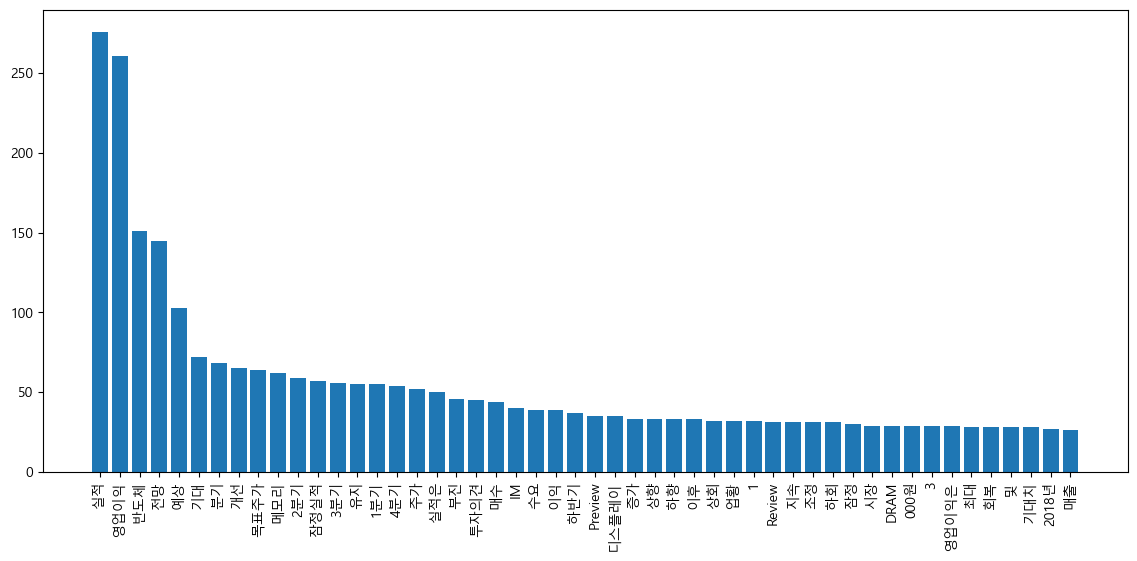

In [196]:
# '제목_세부내용_전처리후' 열에서 NaN 또는 float 값을 빈 문자열로 변환
df_hankyung_consensus['제목_세부내용_전처리후'] = df_hankyung_consensus['제목_세부내용_전처리후'].apply(lambda x: str(x) if isinstance(x, str) else '')

plt.figure(figsize=(14,6))

# 단어 빈도 계산
word_counts = Counter(' '.join(df_hankyung_consensus['제목_세부내용_전처리후']).split())

# 상위 20개 단어 시각화
common_words  = word_counts.most_common()[0:50]
words, counts = zip(*common_words)

plt.bar(words, counts)
plt.xticks(rotation=90)
plt.show()

4. 기본 전처리

In [199]:
# 앞뒤 공백 제거
df_hankyung_consensus.loc[:, '제목_세부내용_전처리후'] = df_hankyung_consensus['제목_세부내용_전처리후'].str.strip()

# 중간 공백 제거
df_hankyung_consensus.loc[:, '제목_세부내용_전처리후'] = df_hankyung_consensus['제목_세부내용_전처리후'].str.replace('\s+', ' ', regex=True)

# # 숫자, 대문자, 소문자 알파벳 및 공백, 한글을 제외한 모든 문자 제거=> stopword에서 제거
# df_hankyung_consensus.loc[:, '제목_세부내용_전처리후'] = df_hankyung_consensus['제목_세부내용_전처리후'].apply(
#     lambda x: re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z0-9\s]', '', str(x))
# )

In [210]:
df_hankyung_consensus[['제목','세부내용','세부내용_전처리후','제목_세부내용_전처리후']][2:6]

,제목,세부내용,세부내용_전처리후,제목_세부내용_전처리후
2,메모리반도체 수익성 개선 본격화,삼성전자(005930) 메모리반도체 수익성 개선 본격화메모리반도체 수익성 개선 본격화,,메모리반도체 수익성 개선 본격화
3,HBM 경쟁 심화 예상,삼성전자(005930) HBM 경쟁 심화 예상HBM 경쟁 심화 예상,,HBM 경쟁 심화 예상
4,TSMC와의 시가총액 격차를 좁혀나 갈 시간,삼성전자(005930) TSMC와의 시가총액 격차를 좁혀나 갈 시간TSMC와의 시가...,,TSMC와의 시가총액 격차를 좁혀나 갈 시간
5,높아지는 HBM3E 공급 가능성,삼성전자(005930) 높아지는 HBM3E 공급 가능성높아지는 HBM3E 공급 가능성,,높아지는 HBM3E 공급 가능성


In [202]:
filtered_df['제목_세부내용_전처리후']

11      Gradual Recovery Ahead 메모리업사이클속 절치부심이후반등전략에주목 ...
31      목표주가 하향 시장은 Cyclical Memory 반도체 주식으로 인식 중인 듯 목...
44                                                목표주가 하향
67      뻔하지만 당연한 최고의 선택 투자의견 매수 목표주가 80 000원 유지 보수적인 공...
71      좀더 구체화된 감산 계획 매수 투자의견 및 목표주가 유지 4Q22 에 메모리 반도체...
                              ...                        
987     Data Center 메모리 모멘텀 지속 에 대해 6개월 목표주가 310만원 12개...
989     사상 최대 실적 전망 하반기 추정 영업이익 31.2조원 반도체 디스플레이 견인 20...
995     2017년 이익 증가 2018년 현금흐름 증가 투자의견 매수 유지. 6개월 목표주가...
1000    3Q17 Preview 를 선호하는 이유 3분분기 OP 14.3조원 반도체 이익증가...
1003    두 가지 모멘텀 모두 유효하다 의 6개월 목표주가를 288만원 2017년 예상 EP...
Name: 제목_세부내용_전처리후, Length: 66, dtype: object

5. 불용어 처리(형태소 분석 선언)

In [112]:
okt=Okt()
hannanum = Hannanum()
kkma=Kkma()
komoran = Komoran()

Okt

In [116]:
#기본 불용어 리스트 정의
stopwords = set([
'!',
'"',
#'$',
#'%',
'&',
"'",
'(',
')',
'*',
#'+',
',',
#'-',
'.',
'...',
# '0',
# '1',
# '2',
# '3',
# '4',
# '5',
# '6',
# '7',
# '8',
# '9',
';',
'<',
'=',
'>',
'?',
'@',
'\\', 
'^',
'_',
'`',
'|',
'~',
'·',
'?',
'??',
'‘',
'’',
'“',
'”',
'…',
'、',
'。',
'〈',
'〉',
'《',
'》',
'가',
'가까스로',
'가령',
'각',
'각각',
'각자',
'각종',
'갖고말하자면',
'같다',
'같이',
'개의치않고',
'거니와',
'거바',
'거의',
'것',
'것과 같이',
'것들',
'게다가',
'게우다',
'겨우',
'견지에서',
'결과에 이르다',
'결국',
'결론을 낼 수 있다',
'겸사겸사',
'고려하면',
'고로',
'곧',
'공동으로',
'과',
'과연',
'관계가 있다',
'관계없이',
'관련이 있다',
'관하여',
'관한',
'관해서는',
'구',
'구체적으로',
'구토하다',
'그',
'그들',
'그때',
'그래',
'그래도',
'그래서',
'그러나',
'그러니',
'그러니까',
'그러면',
'그러므로',
'그러한즉',
'그런 까닭에',
'그런데',
'그런즉',
'그럼',
'그럼에도 불구하고',
'그렇게 함으로써',
'그렇지',
'그렇지 않다면',
'그렇지 않으면',
'그렇지만',
'그렇지않으면',
'그리고',
'그리하여',
'그만이다',
'그에 따르는',
'그위에',
'그저',
'그중에서',
'그치지 않다',
'근거로',
'근거하여',
'기대여',
'기점으로',
'기준으로',
'기타',
'까닭으로',
'까악',
'까지',
'까지 미치다',
'까지도',
'꽈당',
'끙끙',
'끼익',
'나',
'나머지는',
'남들',
'남짓',
'너',
'너희',
'너희들',
'네',
'넷',
'년',
'논하지 않다',
'놀라다',
'누가 알겠는가',
'누구',
'다른',
'다른 방면으로',
'다만',
'다섯',
'다소',
'다수',
'다시 말하자면',
'다시말하면',
'다음',
'다음에',
'다음으로',
'단지',
'답다',
'당신',
'당장',
'대로 하다',
'대하면',
'대하여',
'대해 말하자면',
'대해서',
'댕그',
'더구나',
'더군다나',
'더라도',
'더불어',
'더욱더',
'더욱이는',
'도달하다',
'도착하다',
'동시에',
'동안',
'된바에야',
'된이상',
'두번째로',
'둘',
'둥둥',
'뒤따라',
'뒤이어',
'든간에',
'들',
'등',
'등등',
'딩동',
'따라',
'따라서',
'따위',
'따지지 않다',
'딱',
'때',
'때가 되어',
'때문에',
'또',
'또한',
'뚝뚝',
'라 해도',
'령',
'로',
'로 인하여',
'로부터',
'로써',
'륙',
'를',
'마음대로',
'마저',
'마저도',
'마치',
'막론하고',
'만 못하다',
'만약',
'만약에',
'만은 아니다',
'만이 아니다',
'만일',
'만큼',
'말하자면',
'말할것도 없고',
'매',
'매번',
'메쓰겁다',
'몇',
'모',
'모두',
'무렵',
'무릎쓰고',
'무슨',
'무엇',
'무엇때문에',
'물론',
'및',
'바꾸어말하면',
'바꾸어말하자면',
'바꾸어서 말하면',
'바꾸어서 한다면',
'바꿔 말하면',
'바로',
'바와같이',
'밖에 안된다',
'반대로',
'반대로 말하자면',
'반드시',
'버금',
'보는데서',
'보다더',
'보드득',
'본대로',
'봐',
'봐라',
'부류의 사람들',
'부터',
'불구하고',
'불문하고',
'붕붕',
'비걱거리다',
'비교적',
'비길수 없다',
'비로소',
'비록',
'비슷하다',
'비추어 보아',
'비하면',
'뿐만 아니라',
'뿐만아니라',
'뿐이다',
'삐걱',
'삐걱거리다',
'사',
'삼',
'상대적으로 말하자면',
'생각한대로',
'설령',
'설마',
'설사',
'셋',
'소생',
'소인',
'솨',
'쉿',
'습니까',
'습니다',
'시각',
'시간',
'시작하여',
'시초에',
'시키다',
'실로',
'심지어',
'아',
'아니',
'아니나다를가',
'아니라면',
'아니면',
'아니었다면',
'아래윗',
'아무거나',
'아무도',
'아야',
'아울러',
'아이',
'아이고',
'아이구',
'아이야',
'아이쿠',
'아하',
'아홉',
'안 그러면',
'않기 위하여',
'않기 위해서',
'알 수 있다',
'알았어',
'앗',
'앞에서',
'앞의것',
'야',
'약간',
'양자',
'어',
'어기여차',
'어느',
'어느 년도',
'어느것',
'어느곳',
'어느때',
'어느쪽',
'어느해',
'어디',
'어때',
'어떠한',
'어떤',
'어떤것',
'어떤것들',
'어떻게',
'어떻해',
'어이',
'어째서',
'어쨋든',
'어쩔수 없다',
'어찌',
'어찌됏든',
'어찌됏어',
'어찌하든지',
'어찌하여',
'언제',
'언젠가',
'얼마',
'얼마 안 되는 것',
'얼마간',
'얼마나',
'얼마든지',
'얼마만큼',
'얼마큼',
'엉엉',
'에',
'에 가서',
'에 달려 있다',
'에 대해',
'에 있다',
'에 한하다',
'에게',
'에서',
'여',
'여기',
'여덟',
'여러분',
'여보시오',
'여부',
'여섯',
'여전히',
'여차',
'연관되다',
'연이서',
'영',
'영차',
'옆사람',
'예',
'예를 들면',
'예를 들자면',
'예컨대',
'예하면',
'오',
'오로지',
'오르다',
'오자마자',
'오직',
'오호',
'오히려',
'와',
'와 같은 사람들',
'와르르',
'와아',
'왜',
'왜냐하면',
'외에도',
'요만큼',
'요만한 것',
'요만한걸',
'요컨대',
'우르르',
'우리',
'우리들',
'우선',
'우에 종합한것과같이',
'운운',
'월',
'위에서 서술한바와같이',
'위하여',
'위해서',
'윙윙',
'육',
'으로',
'으로 인하여',
'으로서',
'으로써',
'을',
'응',
'응당',
'의',
'의거하여',
'의지하여',
'의해',
'의해되다',
'의해서',
'이',
'이 되다',
'이 때문에',
'이 밖에',
'이 외에',
'이 정도의',
'이것',
'이곳',
'이때',
'이라면',
'이래',
'이러이러하다',
'이러한',
'이런',
'이럴정도로',
'이렇게 많은 것',
'이렇게되면',
'이렇게말하자면',
'이렇구나',
'이로 인하여',
'이르기까지',
'이리하여',
'이만큼',
'이번',
'이봐',
'이상',
'이어서',
'이었다',
'이와 같다',
'이와 같은',
'이와 반대로',
'이와같다면',
'이외에도',
'이용하여',
'이유만으로',
'이젠',
'이지만',
'이쪽',
'이천구',
'이천육',
'이천칠',
'이천팔',
'인 듯하다',
'인젠',
'일',
'일것이다',
'일곱',
'일단',
'일때',
'일반적으로',
'일지라도',
'임에 틀림없다',
'입각하여',
'입장에서',
'잇따라',
'있다',
'자',
'자기',
'자기집',
'자마자',
'자신',
'잠깐',
'잠시',
'저',
'저것',
'저것만큼',
'저기',
'저쪽',
'저희',
'전부',
'전자',
'전후',
'점에서 보아',
'정도에 이르다',
'제',
'제각기',
'제외하고',
'조금',
'조차',
'조차도',
'졸졸',
'좀',
'좋아',
'좍좍',
'주룩주룩',
'주저하지 않고',
'줄은 몰랏다',
'줄은모른다',
'중에서',
'중의하나',
'즈음하여',
'즉',
'즉시',
'지든지',
'지만',
'지말고',
'진짜로',
'쪽으로',
'차라리',
'참',
'참나',
'첫번째로',
'쳇',
'총적으로',
'총적으로 말하면',
'총적으로 보면',
'칠',
'콸콸',
'쾅쾅',
'쿵',
'타다',
'타인',
'탕탕',
'토하다',
'통하여',
'툭',
'퉤',
'틈타',
'팍',
'팔',
'퍽',
'펄렁',
'하',
'하게될것이다',
'하게하다',
'하겠는가',
'하고 있다',
'하고있었다',
'하곤하였다',
'하구나',
'하기 때문에',
'하기 위하여',
'하기는한데',
'하기만 하면',
'하기보다는',
'하기에',
'하나',
'하느니',
'하는 김에',
'하는 편이 낫다',
'하는것도',
'하는것만 못하다',
'하는것이 낫다',
'하는바',
'하더라도',
'하도다',
'하도록시키다',
'하도록하다',
'하든지',
'하려고하다',
'하마터면',
'하면 할수록',
'하면된다',
'하면서',
'하물며',
'하여금',
'하여야',
'하자마자',
'하지 않는다면',
'하지 않도록',
'하지마',
'하지마라',
'하지만',
'하하',
'한 까닭에',
'한 이유는',
'한 후',
'한다면',
'한다면 몰라도',
'한데',
'한마디',
'한적이있다',
'한켠으로는',
'한항목',
'할 따름이다',
'할 생각이다',
'할 줄 안다',
'할 지경이다',
'할 힘이 있다',
'할때',
'할만하다',
'할망정',
'할뿐',
'할수있다',
'할수있어',
'할줄알다',
'할지라도',
'할지언정',
'함께',
'해도된다',
'해도좋다',
'해봐요',
'해서는 안된다',
'해야한다',
'해요',
'했어요',
'향하다',
'향하여',
'향해서',
'허',
'허걱',
'허허',
'헉',
'헉헉',
'헐떡헐떡',
'형식으로 쓰여',
'혹시',
'혹은',
'혼자',
'훨씬',
'휘익',
'휴',
'흐흐',
'흥',
'힘입어',
'?',
'！',
'＃',
#'＄',
#'％',
'＆',
'（',
'）',
'＊',
'＋',
'，',
# 2ne1 같은 것도 걸러내기 때문에 제외
# '０',
# '１',
# '２',
# '３',
# '４',
# '５',
# '６',
# '７',
# '８',
# '９',
'：',
'；',
'＜',
'＞',
'？',
'＠',
'［',
'］',
'｛',
'｜',
'｝',
'～',
'￥',
'' , # 2014년도 데이터 문제로 추가
'목표주가', # 20240906 멘토링 후 일상 단어 제거 
'투자의견'
])

In [118]:
# 불용어 제거 함수 정의
def remove_stopwords(text):
    # text가 NaN 또는 float인 경우 빈 문자열로 처리
    if isinstance(text, float) or pd.isna(text):
        return ""

    tokens = okt.morphs(text)  # 형태소 단위로 분리
    filtered_tokens = [word for word in tokens if word not in stopwords]
    return ' '.join(filtered_tokens)

# '세부내용' 열에 불용어 제거 함수 적용
df_hankyung_consensus['제목_세부내용_전처리후_Okt'] = df_hankyung_consensus['제목_세부내용_전처리후'].apply(remove_stopwords)

In [119]:
df_hankyung_consensus

,작성일,종목명,종목코드,제목,적정가격,평가의견,작성자,작성기관,세부내용,세부내용_전처리후,제목_세부내용_전처리후,제목_세부내용_전처리후_Okt
0,2024-08-07 00:00:00,삼성전자,005930,추세 하락 이전에 주가 반등 가능할 듯,"87,000",Buy,송명섭,하이투자증권,삼성전자(005930) 추세 하락 이전에 주가 반등 가능할 듯추세 하락 이전에 주가...,,추세 하락 이전에 주가 반등 가능할 듯,추세 하락 이전 주가 반등 가능할 듯
1,2024-08-01 00:00:00,삼성전자,005930,여전히 강력한 AI발 수요 조정기를 거치며 더욱 편해진 주가,"115,000",Buy,"김광진,최영주",한화투자증권,삼성전자(005930) 여전히 강력한 AI발 수요. 조정기를 거치며 더욱 편해진 주...,여전히 강력한 AI발 수요. 조정기를 거치며 더욱 편해진 주가여전히 강력한 AI발...,여전히 강력한 AI발 수요 조정기를 거치며 더욱 편해진 주가 여전히 강력한 AI발 ...,강력한 AI 발 수요 조 정기 거치 며 더욱 편해진 주가 강력한 AI 발 수요 조 ...
2,2024-08-01 00:00:00,삼성전자,005930,메모리반도체 수익성 개선 본격화,"110,000",Buy,백길현,유안타증권,삼성전자(005930) 메모리반도체 수익성 개선 본격화메모리반도체 수익성 개선 본격화,,메모리반도체 수익성 개선 본격화,메모리 반도체 수익 성 개선 본격 화
3,2024-08-01 00:00:00,삼성전자,005930,HBM 경쟁 심화 예상,"97,000",Buy,"송명섭,손우성",하이투자증권,삼성전자(005930) HBM 경쟁 심화 예상HBM 경쟁 심화 예상,,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상
4,2024-08-01 00:00:00,삼성전자,005930,TSMC와의 시가총액 격차를 좁혀나 갈 시간,"110,000",Buy,이승우,유진투자증권,삼성전자(005930) TSMC와의 시가총액 격차를 좁혀나 갈 시간TSMC와의 시가...,,TSMC와의 시가총액 격차를 좁혀나 갈 시간,TSMC 와의 시가총액 격차 좁혀나 갈
...,...,...,...,...,...,...,...,...,...,...,...,...
1008,2017-09-11 00:00:00,삼성전자,005930,3Q17 영업이익 총 15조원 반도체 10조원 전망,"3,100,000",Buy,박유악,키움증권,"삼성전자(005930)3Q17 영업이익 총 15조원, 반도체 10조원 전망3Q17 ...",3Q17 영업이익 15조원 시장 기대치 상회할 전망,3Q17 영업이익 총 15조원 반도체 10조원 전망 3Q17 영업이익 15조원 시장...,3 Q 17 영업 이익 총 15조원 반도체 10조원 전망 3 Q 17 영업 이익 1...
1009,2017-09-08 00:00:00,삼성전자,005930,실적 성장 재개와 함께 강화되는 주주환원,"3,040,000",Buy,김선우,메리츠종금증권,삼성전자(005930)실적 성장 재개와 함께 강화되는 주주환원시장 기대치를 소폭 능...,시장 기대치를 소폭 능가하는 3Q17 영업이익 14.3조원 전망 지속 유지 4Q1...,실적 성장 재개와 함께 강화되는 주주환원 시장 기대치를 소폭 능가하는 3Q17 영업...,실적 성장 재개 강화 되는 주주 환원 시장 기 대치 소 폭 능가 하는 3 Q 17 ...
1010,2017-09-08 00:00:00,삼성전자,005930,3분기 증익을 예상합니다,"3,300,000",Buy,어규진,이베스트증권,삼성전자(005930)3분기 증익을 예상합니다!3분기 영업이익 14.3조원 전망,3분기 영업이익 14.3조원 전망,3분기 증익을 예상합니다 3분기 영업이익 14.3조원 전망,3분 기 증익 예상 합니다 3분 기 영업 이익 14.3조원 전망
1011,2017-09-08 00:00:00,삼성전자,005930,3분기 감익 우려 해소 기대,"3,100,000",Buy,"이순학,김정현",한화투자증권,삼성전자(005930)3분기 감익 우려 해소 기대4분기 서프라이즈 실적 기대,4분기 서프라이즈 실적 기대,3분기 감익 우려 해소 기대 4분기 서프라이즈 실적 기대,3분 기 감익 우려 해소 기대 4분 기 서프라이즈 실적 기대


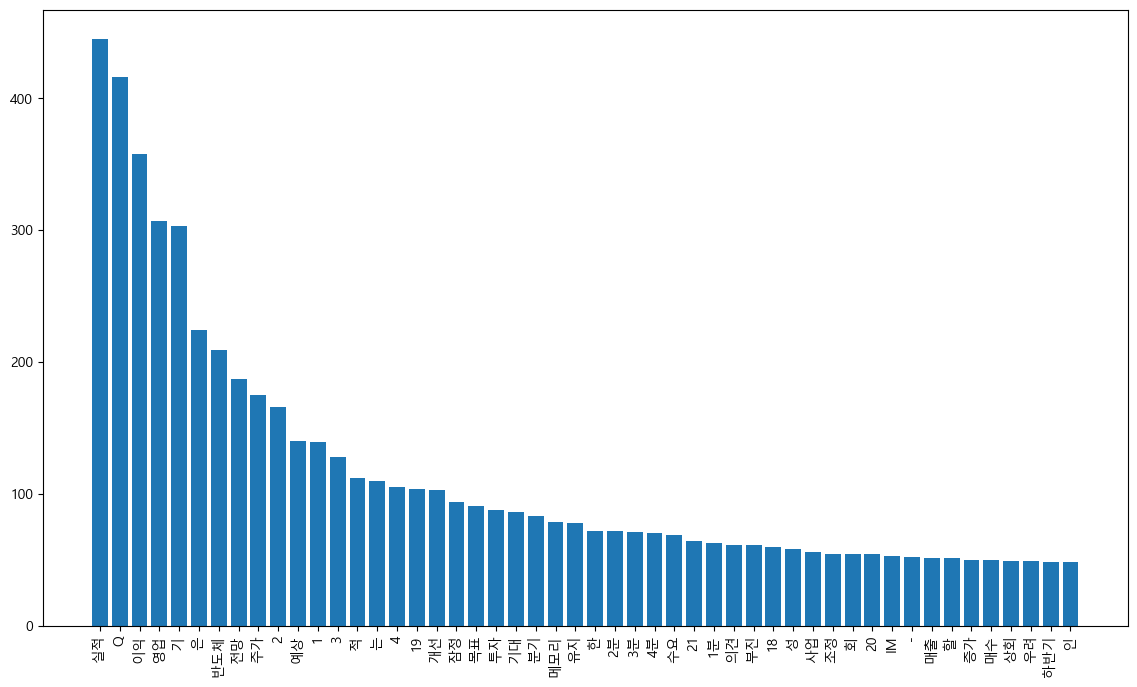

In [120]:
plt.figure(figsize=(14,8))

df_hankyung_consensus['제목_세부내용_전처리후_Okt'] = df_hankyung_consensus['제목_세부내용_전처리후_Okt'].astype(str)

# 단어 빈도 계산
word_counts = Counter(' '.join(df_hankyung_consensus['제목_세부내용_전처리후_Okt']).split())

# 상위 20개 단어 시각화
common_words  = word_counts.most_common()[0:50]  # 21번째에서 40번째 단어
words, counts = zip(*common_words)

plt.bar(words, counts)
plt.xticks(rotation=90)
plt.show()

Hannanum

In [122]:
# 불용어 제거 함수 정의
def remove_stopwords(text):
    # text가 NaN 또는 float인 경우 빈 문자열로 처리
    if isinstance(text, float) or pd.isna(text):
        return ""

    tokens = hannanum.morphs(text)  # 형태소 단위로 분리
    filtered_tokens = [word for word in tokens if word not in stopwords]
    return ' '.join(filtered_tokens)

# '세부내용' 열에 불용어 제거 함수 적용
df_hankyung_consensus['제목_세부내용_전처리후_Hannanum'] = df_hankyung_consensus['제목_세부내용_전처리후'].apply(remove_stopwords)

In [123]:
df_hankyung_consensus[0:50]

,작성일,종목명,종목코드,제목,적정가격,평가의견,작성자,작성기관,세부내용,세부내용_전처리후,제목_세부내용_전처리후,제목_세부내용_전처리후_Okt,제목_세부내용_전처리후_Hannanum
0,2024-08-07 00:00:00,삼성전자,005930,추세 하락 이전에 주가 반등 가능할 듯,"87,000",Buy,송명섭,하이투자증권,삼성전자(005930) 추세 하락 이전에 주가 반등 가능할 듯추세 하락 이전에 주가...,,추세 하락 이전에 주가 반등 가능할 듯,추세 하락 이전 주가 반등 가능할 듯,추세 하락 이전 주 반등 가능 ㄹ 듯
1,2024-08-01 00:00:00,삼성전자,005930,여전히 강력한 AI발 수요 조정기를 거치며 더욱 편해진 주가,"115,000",Buy,"김광진,최영주",한화투자증권,삼성전자(005930) 여전히 강력한 AI발 수요. 조정기를 거치며 더욱 편해진 주...,여전히 강력한 AI발 수요. 조정기를 거치며 더욱 편해진 주가여전히 강력한 AI발...,여전히 강력한 AI발 수요 조정기를 거치며 더욱 편해진 주가 여전히 강력한 AI발 ...,강력한 AI 발 수요 조 정기 거치 며 더욱 편해진 주가 강력한 AI 발 수요 조 ...,강력 ㄴ AI 발 수요 조정기 거치 며 더욱 편하 지 ㄴ 주 강력 ㄴ AI 발 수요...
2,2024-08-01 00:00:00,삼성전자,005930,메모리반도체 수익성 개선 본격화,"110,000",Buy,백길현,유안타증권,삼성전자(005930) 메모리반도체 수익성 개선 본격화메모리반도체 수익성 개선 본격화,,메모리반도체 수익성 개선 본격화,메모리 반도체 수익 성 개선 본격 화,메모리반도체 수익성 개 선 본격화
3,2024-08-01 00:00:00,삼성전자,005930,HBM 경쟁 심화 예상,"97,000",Buy,"송명섭,손우성",하이투자증권,삼성전자(005930) HBM 경쟁 심화 예상HBM 경쟁 심화 예상,,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상
4,2024-08-01 00:00:00,삼성전자,005930,TSMC와의 시가총액 격차를 좁혀나 갈 시간,"110,000",Buy,이승우,유진투자증권,삼성전자(005930) TSMC와의 시가총액 격차를 좁혀나 갈 시간TSMC와의 시가...,,TSMC와의 시가총액 격차를 좁혀나 갈 시간,TSMC 와의 시가총액 격차 좁혀나 갈,TSMC 와의 시가총액 격차 좁히 ㄹ
5,2024-08-01 00:00:00,삼성전자,005930,높아지는 HBM3E 공급 가능성,"110,000",Buy,"신석환,박강호",대신증권,삼성전자(005930) 높아지는 HBM3E 공급 가능성높아지는 HBM3E 공급 가능성,,높아지는 HBM3E 공급 가능성,높아지는 HBM 3 E 공급 가능성,높 지 는 HBM3E 공급 가능성
7,2024-07-05 00:00:00,삼성전자,005930,2Q24P 레거시의 저력을 보여준 서프라이즈,0,NaN,김선우,메리츠증권,삼성전자(005930) 2Q24P- 레거시의 저력을 보여준 서프라이즈2Q24P- 레...,2Q24P- 레거시의 저력을 보여준 서프라이즈2Q24P- 레거시의 저력을 보여준 ...,2Q24P 레거시의 저력을 보여준 서프라이즈 2Q24P- 레거시의 저력을 보여준 서...,2 Q 24 P 레거시 저력 보여준 서프라이즈 2 Q 24 P - 레거시 저력 보여...,2Q24P 레거시 저력 보이 주 ㄴ 서프라이즈 2Q24P- 레거시 저력 보이 주 ㄴ...
8,2024-07-02 00:00:00,삼성전자,005930,메모리 실적 개선 가속화,"110,000",Buy,"신석환,박강호",대신증권,삼성전자(005930) 메모리 실적 개선 가속화메모리 실적 개선 가속화,,메모리 실적 개선 가속화,메모리 실적 개선 가속 화,메모리 실적 개 선 가속화
9,2024-07-02 00:00:00,삼성전자,005930,2Q24 영업이익 8 9조원 전망,"95,500",Buy,송명섭,하이투자증권,삼성전자(005930) 2Q24 영업이익 8.9조원 전망2Q24 영업이익 8.9조원 전망,2Q24 영업이익 8.9조원 전망2Q24 영업이익 8.9조원 전망,2Q24 영업이익 8 9조원 전망 2Q24 영업이익 8.9조원 전망2Q24 영업이익...,2 Q 24 영업 이익 8 9조원 전망 2 Q 24 영업 이익 8.9조원 전망 2 ...,2Q24 영업이익 8 9조원 전망 2Q24 영업이익 8.9조원 전망2Q24 영업이익...
10,2024-06-24 00:00:00,삼성전자,005930,하반기 HBM에서의 성과만 확인된다면,"115,000",Buy,김광진,한화투자증권,삼성전자(005930) 하반기 HBM에서의 성과만 확인된다면2Q24 Preview ...,2Q24 Preview 영업이익 8조원 전망,하반기 HBM에서의 성과만 확인된다면 2Q24 Preview 영업이익 8조원 전망,하반기 HBM 에서의 성과 만 확인 된다면 2 Q 24 Preview 영업 이익 8...,하반기 HBM 에서의 성 과만 확인 되 ㄴ다면 2Q24 Preview 영업이익 8조...


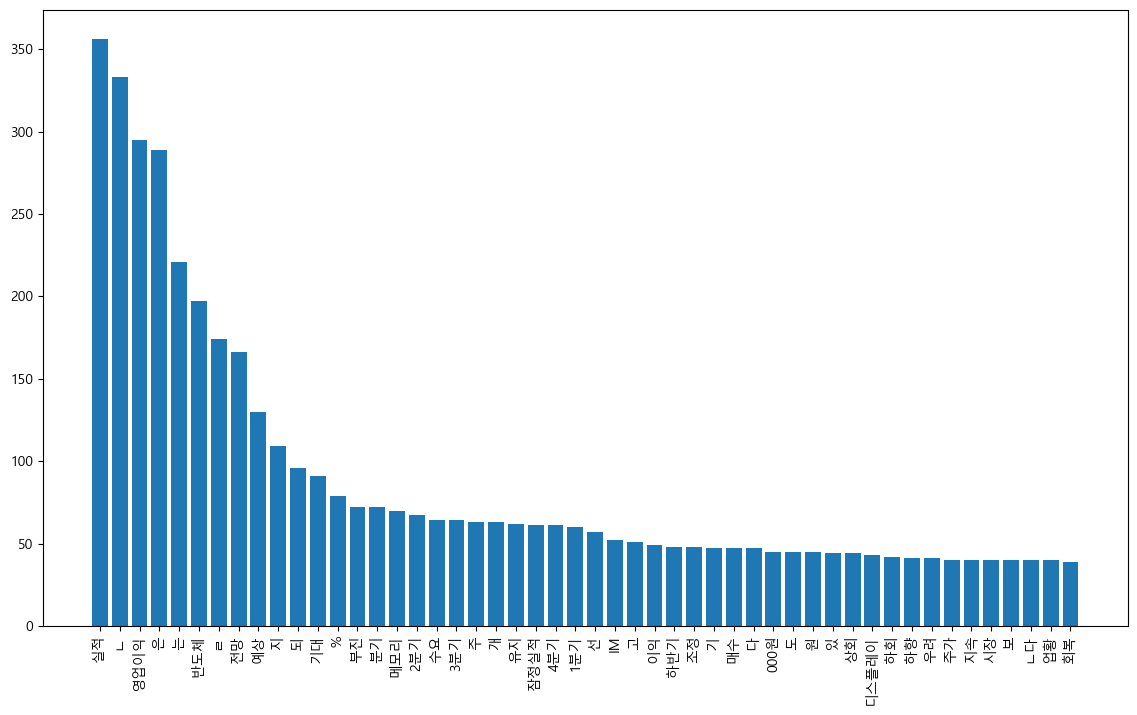

In [124]:
plt.figure(figsize=(14,8))

df_hankyung_consensus['제목_세부내용_전처리후_Hannanum'] = df_hankyung_consensus['제목_세부내용_전처리후_Hannanum'].astype(str)

# 단어 빈도 계산
word_counts = Counter(' '.join(df_hankyung_consensus['제목_세부내용_전처리후_Hannanum']).split())

# 상위 20개 단어 시각화
common_words  = word_counts.most_common()[0:50]  # 21번째에서 40번째 단어
words, counts = zip(*common_words)

plt.bar(words, counts)
plt.xticks(rotation=90)
plt.show()

Kkma

In [126]:
# 불용어 제거 함수 정의
def remove_stopwords(text):
    # text가 NaN 또는 float인 경우 빈 문자열로 처리
    if isinstance(text, float) or pd.isna(text):
        return ""

    tokens = kkma.morphs(text)  # 형태소 단위로 분리
    filtered_tokens = [word for word in tokens if word not in stopwords]
    return ' '.join(filtered_tokens)

# '세부내용' 열에 불용어 제거 함수 적용
df_hankyung_consensus['제목_세부내용_전처리후_Kkma'] = df_hankyung_consensus['제목_세부내용_전처리후'].apply(remove_stopwords)

In [127]:
df_hankyung_consensus[0:50]

,작성일,종목명,종목코드,제목,적정가격,평가의견,작성자,작성기관,세부내용,세부내용_전처리후,제목_세부내용_전처리후,제목_세부내용_전처리후_Okt,제목_세부내용_전처리후_Hannanum,제목_세부내용_전처리후_Kkma
0,2024-08-07 00:00:00,삼성전자,005930,추세 하락 이전에 주가 반등 가능할 듯,"87,000",Buy,송명섭,하이투자증권,삼성전자(005930) 추세 하락 이전에 주가 반등 가능할 듯추세 하락 이전에 주가...,,추세 하락 이전에 주가 반등 가능할 듯,추세 하락 이전 주가 반등 가능할 듯,추세 하락 이전 주 반등 가능 ㄹ 듯,추세 하락 이전 주가 반등 가능 ㄹ 듯
1,2024-08-01 00:00:00,삼성전자,005930,여전히 강력한 AI발 수요 조정기를 거치며 더욱 편해진 주가,"115,000",Buy,"김광진,최영주",한화투자증권,삼성전자(005930) 여전히 강력한 AI발 수요. 조정기를 거치며 더욱 편해진 주...,여전히 강력한 AI발 수요. 조정기를 거치며 더욱 편해진 주가여전히 강력한 AI발...,여전히 강력한 AI발 수요 조정기를 거치며 더욱 편해진 주가 여전히 강력한 AI발 ...,강력한 AI 발 수요 조 정기 거치 며 더욱 편해진 주가 강력한 AI 발 수요 조 ...,강력 ㄴ AI 발 수요 조정기 거치 며 더욱 편하 지 ㄴ 주 강력 ㄴ AI 발 수요...,강력 ㄴ AI 발 수요 조정기 거치 며 더욱 펴 ㄴ 해진 주가 강력 ㄴ AI 발 수...
2,2024-08-01 00:00:00,삼성전자,005930,메모리반도체 수익성 개선 본격화,"110,000",Buy,백길현,유안타증권,삼성전자(005930) 메모리반도체 수익성 개선 본격화메모리반도체 수익성 개선 본격화,,메모리반도체 수익성 개선 본격화,메모리 반도체 수익 성 개선 본격 화,메모리반도체 수익성 개 선 본격화,메모리 반도체 수익성 개선 본격화
3,2024-08-01 00:00:00,삼성전자,005930,HBM 경쟁 심화 예상,"97,000",Buy,"송명섭,손우성",하이투자증권,삼성전자(005930) HBM 경쟁 심화 예상HBM 경쟁 심화 예상,,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상
4,2024-08-01 00:00:00,삼성전자,005930,TSMC와의 시가총액 격차를 좁혀나 갈 시간,"110,000",Buy,이승우,유진투자증권,삼성전자(005930) TSMC와의 시가총액 격차를 좁혀나 갈 시간TSMC와의 시가...,,TSMC와의 시가총액 격차를 좁혀나 갈 시간,TSMC 와의 시가총액 격차 좁혀나 갈,TSMC 와의 시가총액 격차 좁히 ㄹ,TSMC 와의 시가 총액 격차 좁히 ㄹ
5,2024-08-01 00:00:00,삼성전자,005930,높아지는 HBM3E 공급 가능성,"110,000",Buy,"신석환,박강호",대신증권,삼성전자(005930) 높아지는 HBM3E 공급 가능성높아지는 HBM3E 공급 가능성,,높아지는 HBM3E 공급 가능성,높아지는 HBM 3 E 공급 가능성,높 지 는 HBM3E 공급 가능성,높 지 는 HBM 3 E 공급 가능성
7,2024-07-05 00:00:00,삼성전자,005930,2Q24P 레거시의 저력을 보여준 서프라이즈,0,NaN,김선우,메리츠증권,삼성전자(005930) 2Q24P- 레거시의 저력을 보여준 서프라이즈2Q24P- 레...,2Q24P- 레거시의 저력을 보여준 서프라이즈2Q24P- 레거시의 저력을 보여준 ...,2Q24P 레거시의 저력을 보여준 서프라이즈 2Q24P- 레거시의 저력을 보여준 서...,2 Q 24 P 레거시 저력 보여준 서프라이즈 2 Q 24 P - 레거시 저력 보여...,2Q24P 레거시 저력 보이 주 ㄴ 서프라이즈 2Q24P- 레거시 저력 보이 주 ㄴ...,2 Q 24 P 레 거시 저력 보여주 ㄴ 서 프라이 즈 2 Q 24 P - 레 거시...
8,2024-07-02 00:00:00,삼성전자,005930,메모리 실적 개선 가속화,"110,000",Buy,"신석환,박강호",대신증권,삼성전자(005930) 메모리 실적 개선 가속화메모리 실적 개선 가속화,,메모리 실적 개선 가속화,메모리 실적 개선 가속 화,메모리 실적 개 선 가속화,메모리 실적 개선 가속화
9,2024-07-02 00:00:00,삼성전자,005930,2Q24 영업이익 8 9조원 전망,"95,500",Buy,송명섭,하이투자증권,삼성전자(005930) 2Q24 영업이익 8.9조원 전망2Q24 영업이익 8.9조원 전망,2Q24 영업이익 8.9조원 전망2Q24 영업이익 8.9조원 전망,2Q24 영업이익 8 9조원 전망 2Q24 영업이익 8.9조원 전망2Q24 영업이익...,2 Q 24 영업 이익 8 9조원 전망 2 Q 24 영업 이익 8.9조원 전망 2 ...,2Q24 영업이익 8 9조원 전망 2Q24 영업이익 8.9조원 전망2Q24 영업이익...,2 Q 24 영업 이익 8 9 조 원 전망 2 Q 24 영업 이익 8.9 조 원 전...
10,2024-06-24 00:00:00,삼성전자,005930,하반기 HBM에서의 성과만 확인된다면,"115,000",Buy,김광진,한화투자증권,삼성전자(005930) 하반기 HBM에서의 성과만 확인된다면2Q24 Preview ...,2Q24 Preview 영업이익 8조원 전망,하반기 HBM에서의 성과만 확인된다면 2Q24 Preview 영업이익 8조원 전망,하반기 HBM 에서의 성과 만 확인 된다면 2 Q 24 Preview 영업 이익 8...,하반기 HBM 에서의 성 과만 확인 되 ㄴ다면 2Q24 Preview 영업이익 8조...,하반기 HBM 성과 만 확인 되 ㄴ다면 2 Q 24 Preview 영업 이익 8 조...


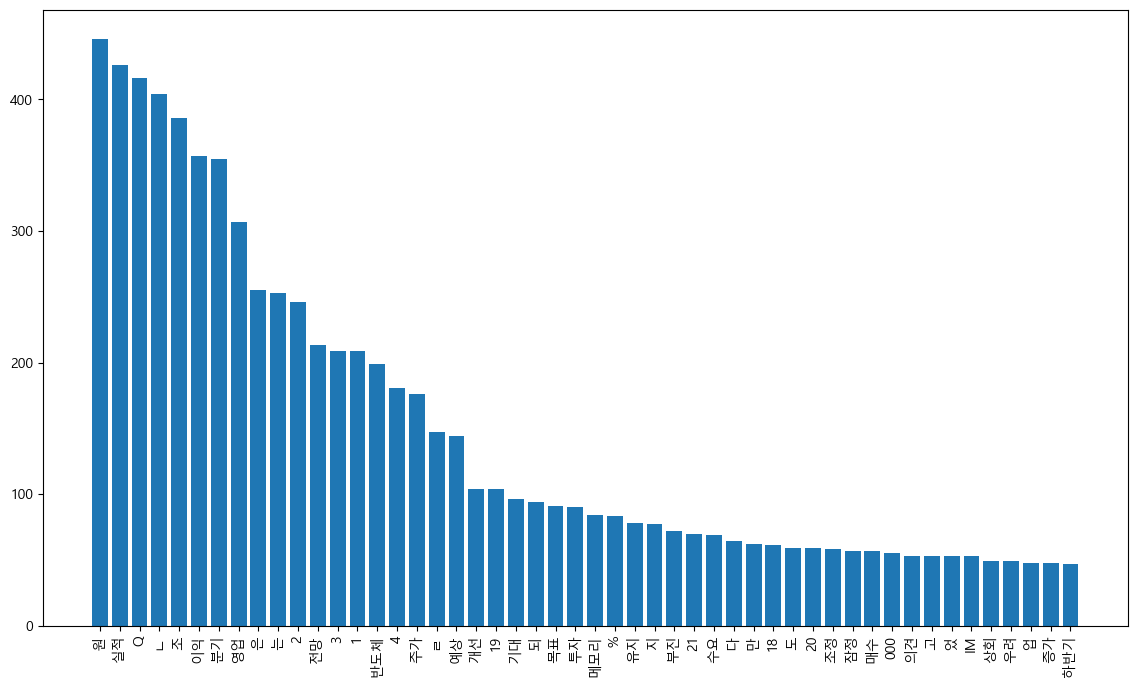

In [128]:
plt.figure(figsize=(14,8))

df_hankyung_consensus['제목_세부내용_전처리후_Kkma'] = df_hankyung_consensus['제목_세부내용_전처리후_Kkma'].astype(str)

# 단어 빈도 계산
word_counts = Counter(' '.join(df_hankyung_consensus['제목_세부내용_전처리후_Kkma']).split())

# 상위 20개 단어 시각화
common_words  = word_counts.most_common()[0:50]  # 21번째에서 40번째 단어
words, counts = zip(*common_words)

plt.bar(words, counts)
plt.xticks(rotation=90)
plt.show()

Komoran

In [130]:
# 불용어 제거 함수 정의
def remove_stopwords(text):
    # text가 NaN 또는 float인 경우 빈 문자열로 처리
    if isinstance(text, float) or pd.isna(text):
        return ""

    tokens = komoran.morphs(text)  # 형태소 단위로 분리
    filtered_tokens = [word for word in tokens if word not in stopwords]
    return ' '.join(filtered_tokens)

# '세부내용' 열에 불용어 제거 함수 적용
df_hankyung_consensus['제목_세부내용_전처리후_Komoran'] = df_hankyung_consensus['제목_세부내용_전처리후'].apply(remove_stopwords)

In [131]:
df_hankyung_consensus[0:50]

,작성일,종목명,종목코드,제목,적정가격,평가의견,작성자,작성기관,세부내용,세부내용_전처리후,제목_세부내용_전처리후,제목_세부내용_전처리후_Okt,제목_세부내용_전처리후_Hannanum,제목_세부내용_전처리후_Kkma,제목_세부내용_전처리후_Komoran
0,2024-08-07 00:00:00,삼성전자,005930,추세 하락 이전에 주가 반등 가능할 듯,"87,000",Buy,송명섭,하이투자증권,삼성전자(005930) 추세 하락 이전에 주가 반등 가능할 듯추세 하락 이전에 주가...,,추세 하락 이전에 주가 반등 가능할 듯,추세 하락 이전 주가 반등 가능할 듯,추세 하락 이전 주 반등 가능 ㄹ 듯,추세 하락 이전 주가 반등 가능 ㄹ 듯,추세 하락 이전 주가 반등 가능 ㄹ 듯
1,2024-08-01 00:00:00,삼성전자,005930,여전히 강력한 AI발 수요 조정기를 거치며 더욱 편해진 주가,"115,000",Buy,"김광진,최영주",한화투자증권,삼성전자(005930) 여전히 강력한 AI발 수요. 조정기를 거치며 더욱 편해진 주...,여전히 강력한 AI발 수요. 조정기를 거치며 더욱 편해진 주가여전히 강력한 AI발...,여전히 강력한 AI발 수요 조정기를 거치며 더욱 편해진 주가 여전히 강력한 AI발 ...,강력한 AI 발 수요 조 정기 거치 며 더욱 편해진 주가 강력한 AI 발 수요 조 ...,강력 ㄴ AI 발 수요 조정기 거치 며 더욱 편하 지 ㄴ 주 강력 ㄴ AI 발 수요...,강력 ㄴ AI 발 수요 조정기 거치 며 더욱 펴 ㄴ 해진 주가 강력 ㄴ AI 발 수...,강력 ㄴ AI 발 수요 조정 기 거치 며 더욱 편 해진 주가 강력 ㄴ AI 발 수요...
2,2024-08-01 00:00:00,삼성전자,005930,메모리반도체 수익성 개선 본격화,"110,000",Buy,백길현,유안타증권,삼성전자(005930) 메모리반도체 수익성 개선 본격화메모리반도체 수익성 개선 본격화,,메모리반도체 수익성 개선 본격화,메모리 반도체 수익 성 개선 본격 화,메모리반도체 수익성 개 선 본격화,메모리 반도체 수익성 개선 본격화,메모리 반도체 수익 성 개선 본격 화
3,2024-08-01 00:00:00,삼성전자,005930,HBM 경쟁 심화 예상,"97,000",Buy,"송명섭,손우성",하이투자증권,삼성전자(005930) HBM 경쟁 심화 예상HBM 경쟁 심화 예상,,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상
4,2024-08-01 00:00:00,삼성전자,005930,TSMC와의 시가총액 격차를 좁혀나 갈 시간,"110,000",Buy,이승우,유진투자증권,삼성전자(005930) TSMC와의 시가총액 격차를 좁혀나 갈 시간TSMC와의 시가...,,TSMC와의 시가총액 격차를 좁혀나 갈 시간,TSMC 와의 시가총액 격차 좁혀나 갈,TSMC 와의 시가총액 격차 좁히 ㄹ,TSMC 와의 시가 총액 격차 좁히 ㄹ,TSMC 시가총액 격차 좁히 ㄹ
5,2024-08-01 00:00:00,삼성전자,005930,높아지는 HBM3E 공급 가능성,"110,000",Buy,"신석환,박강호",대신증권,삼성전자(005930) 높아지는 HBM3E 공급 가능성높아지는 HBM3E 공급 가능성,,높아지는 HBM3E 공급 가능성,높아지는 HBM 3 E 공급 가능성,높 지 는 HBM3E 공급 가능성,높 지 는 HBM 3 E 공급 가능성,높 지 는 HBM 3 E 공급 가능 성
7,2024-07-05 00:00:00,삼성전자,005930,2Q24P 레거시의 저력을 보여준 서프라이즈,0,NaN,김선우,메리츠증권,삼성전자(005930) 2Q24P- 레거시의 저력을 보여준 서프라이즈2Q24P- 레...,2Q24P- 레거시의 저력을 보여준 서프라이즈2Q24P- 레거시의 저력을 보여준 ...,2Q24P 레거시의 저력을 보여준 서프라이즈 2Q24P- 레거시의 저력을 보여준 서...,2 Q 24 P 레거시 저력 보여준 서프라이즈 2 Q 24 P - 레거시 저력 보여...,2Q24P 레거시 저력 보이 주 ㄴ 서프라이즈 2Q24P- 레거시 저력 보이 주 ㄴ...,2 Q 24 P 레 거시 저력 보여주 ㄴ 서 프라이 즈 2 Q 24 P - 레 거시...,2 Q 24 P 레거시 저력 보이 주 ㄴ 서프라이즈 2 Q 24 P - 레거시 저력...
8,2024-07-02 00:00:00,삼성전자,005930,메모리 실적 개선 가속화,"110,000",Buy,"신석환,박강호",대신증권,삼성전자(005930) 메모리 실적 개선 가속화메모리 실적 개선 가속화,,메모리 실적 개선 가속화,메모리 실적 개선 가속 화,메모리 실적 개 선 가속화,메모리 실적 개선 가속화,메모리 실적 개선 가속 화
9,2024-07-02 00:00:00,삼성전자,005930,2Q24 영업이익 8 9조원 전망,"95,500",Buy,송명섭,하이투자증권,삼성전자(005930) 2Q24 영업이익 8.9조원 전망2Q24 영업이익 8.9조원 전망,2Q24 영업이익 8.9조원 전망2Q24 영업이익 8.9조원 전망,2Q24 영업이익 8 9조원 전망 2Q24 영업이익 8.9조원 전망2Q24 영업이익...,2 Q 24 영업 이익 8 9조원 전망 2 Q 24 영업 이익 8.9조원 전망 2 ...,2Q24 영업이익 8 9조원 전망 2Q24 영업이익 8.9조원 전망2Q24 영업이익...,2 Q 24 영업 이익 8 9 조 원 전망 2 Q 24 영업 이익 8.9 조 원 전...,2 Q 24 영업 이익 8 9 조 원 전망 2 Q 24 영업 이익 8 9 조 원 전...
10,2024-06-24 00:00:00,삼성전자,005930,하반기 HBM에서의 성과만 확인된다면,"115,000",Buy,김광진,한화투자증권,삼성전자(005930) 하반기 HBM에서의 성과만 확인된다면2Q24 Preview ...,2Q24 Preview 영업이익 8조원 전망,하반기 HBM에서의 성과만 확인된다면 2Q24 Preview 영업이익 8조원 전망,하반기 HBM 에서의 성과 만 확인 된다면 2 Q 24 Preview 영업 이익 8...,하반기 HBM 에서의 성 과만 확인 되 ㄴ다면 2Q24 Preview 영업이익 8조...,하반기 HBM 성과 만 확인 되 ㄴ다면 2 Q 24 Preview 영업 이익 8 조...,하반기 HBM 성과 만 확인 되 ㄴ다면 2 Q 24 Preview 영업 이익 8 조...


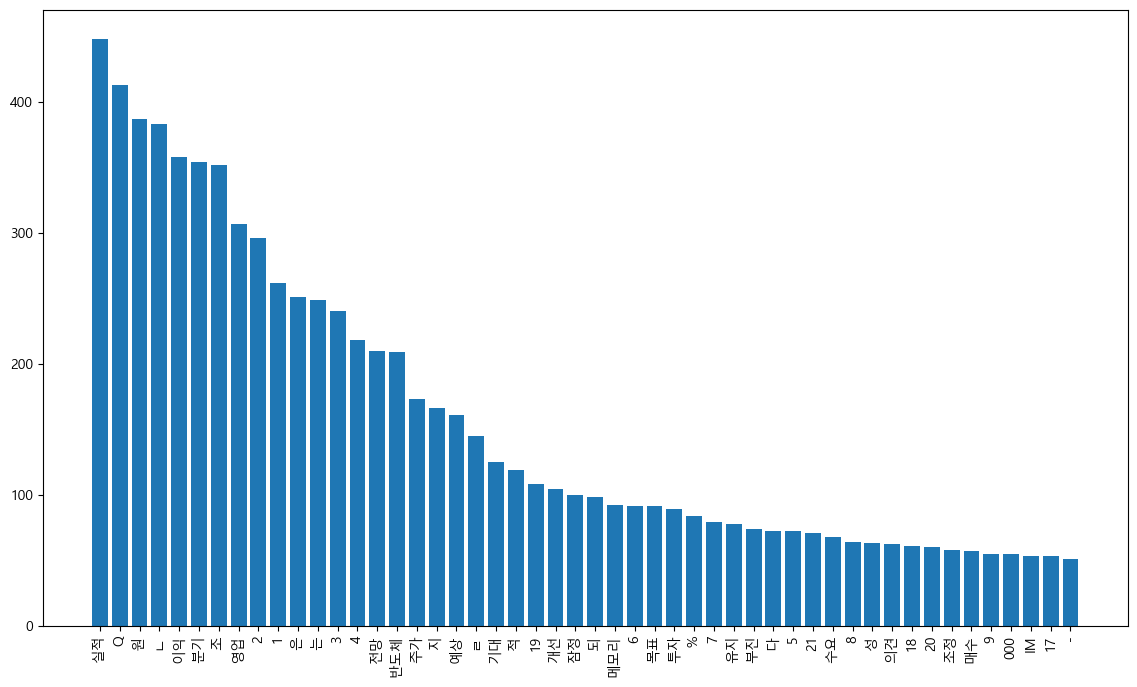

In [132]:
plt.figure(figsize=(14,8))

df_hankyung_consensus['제목_세부내용_전처리후_Komoran'] = df_hankyung_consensus['제목_세부내용_전처리후_Komoran'].astype(str)

# 단어 빈도 계산
word_counts = Counter(' '.join(df_hankyung_consensus['제목_세부내용_전처리후_Komoran']).split())

# 상위 20개 단어 시각화
common_words  = word_counts.most_common()[0:50]  # 21번째에서 40번째 단어
words, counts = zip(*common_words)

plt.bar(words, counts)
plt.xticks(rotation=90)
plt.show()

형태소 분석 성능이 만족스럽지 않아 키위 설치

In [134]:
from kiwipiepy import Kiwi

# Kiwi 객체 생성
kiwi = Kiwi()
# 시간 측정 시작
start_time = time.time()

# 텍스트를 형태소 분석하여 결과를 반환하는 함수
def analyze_text(text):
    result = kiwi.analyze(text)
    return result

# 형태소 분석 결과에서 명사를 추출하는 함수
def extract_nouns(text):
    nouns = []
    result = analyze_text(text)
    for token, pos, _, _ in result[0][0]:
        # 명사,알파벳,숫자
        # NNB : 11.1배의 배포함
        if len(token) != 1 and (pos.startswith('N') or pos.startswith('SL') or pos.startswith('VA') or
                                pos.startswith('SN') or pos.startswith('SF') or pos.startswith('SS') or
                                pos.startswith('MM') or pos.startswith('SY') or pos.startswith('NNB')):
            nouns.append(token)
    return nouns

# 텍스트 예시
tokenized_texts = [extract_nouns(text) for text in df_hankyung_consensus['제목_세부내용_전처리후']]

# 시간 측정 종료
end_time = time.time()

# 토큰화 시간 출력
print(f"Tokenization time: {end_time - start_time} seconds")
#print(tokenized_texts)

Tokenization time: 1.5944719314575195 seconds


In [135]:
# '세부내용' 열에 불용어 제거 함수 적용
def remove_stopwords(text):
    # text가 NaN 또는 float인 경우 빈 문자열로 처리
    if isinstance(text, float) or pd.isna(text):
        return ""

    tokens = extract_nouns(text)
    filtered_tokens = [word for word in tokens if word not in stopwords]
    return ' '.join(filtered_tokens)

df_hankyung_consensus['제목_세부내용_전처리후_kiwi'] = df_hankyung_consensus['제목_세부내용_전처리후'].apply(remove_stopwords)

In [138]:
df_hankyung_consensus[0:50]

,작성일,종목명,종목코드,제목,적정가격,평가의견,작성자,작성기관,세부내용,세부내용_전처리후,제목_세부내용_전처리후,제목_세부내용_전처리후_Okt,제목_세부내용_전처리후_Hannanum,제목_세부내용_전처리후_Kkma,제목_세부내용_전처리후_Komoran,제목_세부내용_전처리후_kiwi
0,2024-08-07 00:00:00,삼성전자,005930,추세 하락 이전에 주가 반등 가능할 듯,"87,000",Buy,송명섭,하이투자증권,삼성전자(005930) 추세 하락 이전에 주가 반등 가능할 듯추세 하락 이전에 주가...,,추세 하락 이전에 주가 반등 가능할 듯,추세 하락 이전 주가 반등 가능할 듯,추세 하락 이전 주 반등 가능 ㄹ 듯,추세 하락 이전 주가 반등 가능 ㄹ 듯,추세 하락 이전 주가 반등 가능 ㄹ 듯,추세 하락 이전 주가 반등 가능
1,2024-08-01 00:00:00,삼성전자,005930,여전히 강력한 AI발 수요 조정기를 거치며 더욱 편해진 주가,"115,000",Buy,"김광진,최영주",한화투자증권,삼성전자(005930) 여전히 강력한 AI발 수요. 조정기를 거치며 더욱 편해진 주...,여전히 강력한 AI발 수요. 조정기를 거치며 더욱 편해진 주가여전히 강력한 AI발...,여전히 강력한 AI발 수요 조정기를 거치며 더욱 편해진 주가 여전히 강력한 AI발 ...,강력한 AI 발 수요 조 정기 거치 며 더욱 편해진 주가 강력한 AI 발 수요 조 ...,강력 ㄴ AI 발 수요 조정기 거치 며 더욱 편하 지 ㄴ 주 강력 ㄴ AI 발 수요...,강력 ㄴ AI 발 수요 조정기 거치 며 더욱 펴 ㄴ 해진 주가 강력 ㄴ AI 발 수...,강력 ㄴ AI 발 수요 조정 기 거치 며 더욱 편 해진 주가 강력 ㄴ AI 발 수요...,AI 수요 조정기 편하 AI 수요 조정기 편하 AI 수요 조정기 편하 주가
2,2024-08-01 00:00:00,삼성전자,005930,메모리반도체 수익성 개선 본격화,"110,000",Buy,백길현,유안타증권,삼성전자(005930) 메모리반도체 수익성 개선 본격화메모리반도체 수익성 개선 본격화,,메모리반도체 수익성 개선 본격화,메모리 반도체 수익 성 개선 본격 화,메모리반도체 수익성 개 선 본격화,메모리 반도체 수익성 개선 본격화,메모리 반도체 수익 성 개선 본격 화,메모리 반도체 수익 개선 본격
3,2024-08-01 00:00:00,삼성전자,005930,HBM 경쟁 심화 예상,"97,000",Buy,"송명섭,손우성",하이투자증권,삼성전자(005930) HBM 경쟁 심화 예상HBM 경쟁 심화 예상,,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상
4,2024-08-01 00:00:00,삼성전자,005930,TSMC와의 시가총액 격차를 좁혀나 갈 시간,"110,000",Buy,이승우,유진투자증권,삼성전자(005930) TSMC와의 시가총액 격차를 좁혀나 갈 시간TSMC와의 시가...,,TSMC와의 시가총액 격차를 좁혀나 갈 시간,TSMC 와의 시가총액 격차 좁혀나 갈,TSMC 와의 시가총액 격차 좁히 ㄹ,TSMC 와의 시가 총액 격차 좁히 ㄹ,TSMC 시가총액 격차 좁히 ㄹ,TSMC 시가 총액 격차
5,2024-08-01 00:00:00,삼성전자,005930,높아지는 HBM3E 공급 가능성,"110,000",Buy,"신석환,박강호",대신증권,삼성전자(005930) 높아지는 HBM3E 공급 가능성높아지는 HBM3E 공급 가능성,,높아지는 HBM3E 공급 가능성,높아지는 HBM 3 E 공급 가능성,높 지 는 HBM3E 공급 가능성,높 지 는 HBM 3 E 공급 가능성,높 지 는 HBM 3 E 공급 가능 성,HBM 공급 가능
7,2024-07-05 00:00:00,삼성전자,005930,2Q24P 레거시의 저력을 보여준 서프라이즈,0,NaN,김선우,메리츠증권,삼성전자(005930) 2Q24P- 레거시의 저력을 보여준 서프라이즈2Q24P- 레...,2Q24P- 레거시의 저력을 보여준 서프라이즈2Q24P- 레거시의 저력을 보여준 ...,2Q24P 레거시의 저력을 보여준 서프라이즈 2Q24P- 레거시의 저력을 보여준 서...,2 Q 24 P 레거시 저력 보여준 서프라이즈 2 Q 24 P - 레거시 저력 보여...,2Q24P 레거시 저력 보이 주 ㄴ 서프라이즈 2Q24P- 레거시 저력 보이 주 ㄴ...,2 Q 24 P 레 거시 저력 보여주 ㄴ 서 프라이 즈 2 Q 24 P - 레 거시...,2 Q 24 P 레거시 저력 보이 주 ㄴ 서프라이즈 2 Q 24 P - 레거시 저력...,24 레거시 저력 서프라이즈 24 레거시 저력 서프라이즈 24 레거시 저력 서프라이즈
8,2024-07-02 00:00:00,삼성전자,005930,메모리 실적 개선 가속화,"110,000",Buy,"신석환,박강호",대신증권,삼성전자(005930) 메모리 실적 개선 가속화메모리 실적 개선 가속화,,메모리 실적 개선 가속화,메모리 실적 개선 가속 화,메모리 실적 개 선 가속화,메모리 실적 개선 가속화,메모리 실적 개선 가속 화,메모리 실적 개선 가속
9,2024-07-02 00:00:00,삼성전자,005930,2Q24 영업이익 8 9조원 전망,"95,500",Buy,송명섭,하이투자증권,삼성전자(005930) 2Q24 영업이익 8.9조원 전망2Q24 영업이익 8.9조원 전망,2Q24 영업이익 8.9조원 전망2Q24 영업이익 8.9조원 전망,2Q24 영업이익 8 9조원 전망 2Q24 영업이익 8.9조원 전망2Q24 영업이익...,2 Q 24 영업 이익 8 9조원 전망 2 Q 24 영업 이익 8.9조원 전망 2 ...,2Q24 영업이익 8 9조원 전망 2Q24 영업이익 8.9조원 전망2Q24 영업이익...,2 Q 24 영업 이익 8 9 조 원 전망 2 Q 24 영업 이익 8.9 조 원 전...,2 Q 24 영업 이익 8 9 조 원 전망 2 Q 24 영업 이익 8 9 조 원 전...,24 영업 이익 전망 24 영업 이익 8.9 전망 24 영업 이익 8.9 전망
10,2024-06-24 00:00:00,삼성전자,005930,하반기 HBM에서의 성과만 확인된다면,"115,000",Buy,김광진,한화투자증권,삼성전자(005930) 하반기 HBM에서의 성과만 확인된다면2Q24 Preview ...,2Q24 Preview 영업이익 8조원 전망,하반기 HBM에서의 성과만 확인된다면 2Q24 Preview 영업이익 8조원 전망,하반기 HBM 에서의 성과 만 확인 된다면 2 Q 24 Preview 영업 이익 8...,하반기 HBM 에서의 성 과만 확인 되 ㄴ다면 2Q24 Preview 영업이익 8조...,하반기 HBM 성과 만 확인 되 ㄴ다면 2 Q 24 Preview 영업 이익 8 조...,하반기 HBM 성과 만 확인 되 ㄴ다면 2 Q 24 Preview 영업 이익 8 조...,하반기 HBM 성과 확인 24 Preview 영업 이익 전망


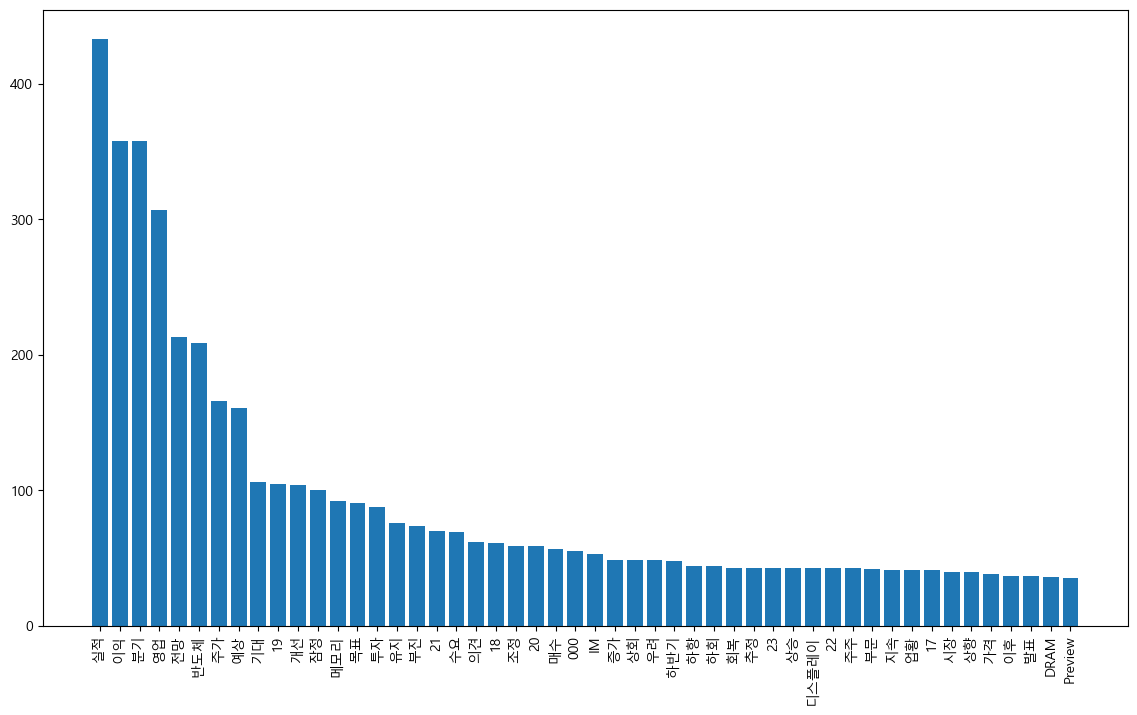

In [140]:
plt.figure(figsize=(14,8))

df_hankyung_consensus['제목_세부내용_전처리후_kiwi'] = df_hankyung_consensus['제목_세부내용_전처리후_kiwi'].astype(str)

# 단어 빈도 계산
word_counts = Counter(' '.join(df_hankyung_consensus['제목_세부내용_전처리후_kiwi']).split())

# 상위 20개 단어 시각화
common_words  = word_counts.most_common()[0:50]  # 21번째에서 40번째 단어
words, counts = zip(*common_words)

plt.bar(words, counts)
plt.xticks(rotation=90)
plt.show()

Komoran_명사

In [142]:
# '세부내용' 열에 불용어 제거 함수 적용
def remove_stopwords(text):
    # text가 NaN 또는 float인 경우 빈 문자열로 처리
    if isinstance(text, float) or pd.isna(text):
        return ""

    tokens = komoran.nouns(text)  # 형태소 단위로 분리
    filtered_tokens = [word for word in tokens if word not in stopwords]
    return ' '.join(filtered_tokens)

df_hankyung_consensus['제목_세부내용_전처리후_Komoran_명사'] = df_hankyung_consensus['제목_세부내용_전처리후'].apply(remove_stopwords)

In [143]:
df_hankyung_consensus[0:50]

,작성일,종목명,종목코드,제목,적정가격,평가의견,작성자,작성기관,세부내용,세부내용_전처리후,제목_세부내용_전처리후,제목_세부내용_전처리후_Okt,제목_세부내용_전처리후_Hannanum,제목_세부내용_전처리후_Kkma,제목_세부내용_전처리후_Komoran,제목_세부내용_전처리후_kiwi,제목_세부내용_전처리후_Komoran_명사
0,2024-08-07 00:00:00,삼성전자,005930,추세 하락 이전에 주가 반등 가능할 듯,"87,000",Buy,송명섭,하이투자증권,삼성전자(005930) 추세 하락 이전에 주가 반등 가능할 듯추세 하락 이전에 주가...,,추세 하락 이전에 주가 반등 가능할 듯,추세 하락 이전 주가 반등 가능할 듯,추세 하락 이전 주 반등 가능 ㄹ 듯,추세 하락 이전 주가 반등 가능 ㄹ 듯,추세 하락 이전 주가 반등 가능 ㄹ 듯,추세 하락 이전 주가 반등 가능,추세 하락 이전 주가 반등 듯
1,2024-08-01 00:00:00,삼성전자,005930,여전히 강력한 AI발 수요 조정기를 거치며 더욱 편해진 주가,"115,000",Buy,"김광진,최영주",한화투자증권,삼성전자(005930) 여전히 강력한 AI발 수요. 조정기를 거치며 더욱 편해진 주...,여전히 강력한 AI발 수요. 조정기를 거치며 더욱 편해진 주가여전히 강력한 AI발...,여전히 강력한 AI발 수요 조정기를 거치며 더욱 편해진 주가 여전히 강력한 AI발 ...,강력한 AI 발 수요 조 정기 거치 며 더욱 편해진 주가 강력한 AI 발 수요 조 ...,강력 ㄴ AI 발 수요 조정기 거치 며 더욱 편하 지 ㄴ 주 강력 ㄴ AI 발 수요...,강력 ㄴ AI 발 수요 조정기 거치 며 더욱 펴 ㄴ 해진 주가 강력 ㄴ AI 발 수...,강력 ㄴ AI 발 수요 조정 기 거치 며 더욱 편 해진 주가 강력 ㄴ AI 발 수요...,AI 수요 조정기 편하 AI 수요 조정기 편하 AI 수요 조정기 편하 주가,발 수요 조정 편 해진 주가 발 수요 조정 편 해진 주가 발 수요 조정 편 해진 주가
2,2024-08-01 00:00:00,삼성전자,005930,메모리반도체 수익성 개선 본격화,"110,000",Buy,백길현,유안타증권,삼성전자(005930) 메모리반도체 수익성 개선 본격화메모리반도체 수익성 개선 본격화,,메모리반도체 수익성 개선 본격화,메모리 반도체 수익 성 개선 본격 화,메모리반도체 수익성 개 선 본격화,메모리 반도체 수익성 개선 본격화,메모리 반도체 수익 성 개선 본격 화,메모리 반도체 수익 개선 본격,메모리 반도체 수익 개선
3,2024-08-01 00:00:00,삼성전자,005930,HBM 경쟁 심화 예상,"97,000",Buy,"송명섭,손우성",하이투자증권,삼성전자(005930) HBM 경쟁 심화 예상HBM 경쟁 심화 예상,,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,경쟁 심화 예상
4,2024-08-01 00:00:00,삼성전자,005930,TSMC와의 시가총액 격차를 좁혀나 갈 시간,"110,000",Buy,이승우,유진투자증권,삼성전자(005930) TSMC와의 시가총액 격차를 좁혀나 갈 시간TSMC와의 시가...,,TSMC와의 시가총액 격차를 좁혀나 갈 시간,TSMC 와의 시가총액 격차 좁혀나 갈,TSMC 와의 시가총액 격차 좁히 ㄹ,TSMC 와의 시가 총액 격차 좁히 ㄹ,TSMC 시가총액 격차 좁히 ㄹ,TSMC 시가 총액 격차,시가총액 격차
5,2024-08-01 00:00:00,삼성전자,005930,높아지는 HBM3E 공급 가능성,"110,000",Buy,"신석환,박강호",대신증권,삼성전자(005930) 높아지는 HBM3E 공급 가능성높아지는 HBM3E 공급 가능성,,높아지는 HBM3E 공급 가능성,높아지는 HBM 3 E 공급 가능성,높 지 는 HBM3E 공급 가능성,높 지 는 HBM 3 E 공급 가능성,높 지 는 HBM 3 E 공급 가능 성,HBM 공급 가능,공급
7,2024-07-05 00:00:00,삼성전자,005930,2Q24P 레거시의 저력을 보여준 서프라이즈,0,NaN,김선우,메리츠증권,삼성전자(005930) 2Q24P- 레거시의 저력을 보여준 서프라이즈2Q24P- 레...,2Q24P- 레거시의 저력을 보여준 서프라이즈2Q24P- 레거시의 저력을 보여준 ...,2Q24P 레거시의 저력을 보여준 서프라이즈 2Q24P- 레거시의 저력을 보여준 서...,2 Q 24 P 레거시 저력 보여준 서프라이즈 2 Q 24 P - 레거시 저력 보여...,2Q24P 레거시 저력 보이 주 ㄴ 서프라이즈 2Q24P- 레거시 저력 보이 주 ㄴ...,2 Q 24 P 레 거시 저력 보여주 ㄴ 서 프라이 즈 2 Q 24 P - 레 거시...,2 Q 24 P 레거시 저력 보이 주 ㄴ 서프라이즈 2 Q 24 P - 레거시 저력...,24 레거시 저력 서프라이즈 24 레거시 저력 서프라이즈 24 레거시 저력 서프라이즈,레거시 저력 서프라이즈 레거시 저력 서프라이즈 레거시 저력 서프라이즈
8,2024-07-02 00:00:00,삼성전자,005930,메모리 실적 개선 가속화,"110,000",Buy,"신석환,박강호",대신증권,삼성전자(005930) 메모리 실적 개선 가속화메모리 실적 개선 가속화,,메모리 실적 개선 가속화,메모리 실적 개선 가속 화,메모리 실적 개 선 가속화,메모리 실적 개선 가속화,메모리 실적 개선 가속 화,메모리 실적 개선 가속,메모리 실적 개선 가속
9,2024-07-02 00:00:00,삼성전자,005930,2Q24 영업이익 8 9조원 전망,"95,500",Buy,송명섭,하이투자증권,삼성전자(005930) 2Q24 영업이익 8.9조원 전망2Q24 영업이익 8.9조원 전망,2Q24 영업이익 8.9조원 전망2Q24 영업이익 8.9조원 전망,2Q24 영업이익 8 9조원 전망 2Q24 영업이익 8.9조원 전망2Q24 영업이익...,2 Q 24 영업 이익 8 9조원 전망 2 Q 24 영업 이익 8.9조원 전망 2 ...,2Q24 영업이익 8 9조원 전망 2Q24 영업이익 8.9조원 전망2Q24 영업이익...,2 Q 24 영업 이익 8 9 조 원 전망 2 Q 24 영업 이익 8.9 조 원 전...,2 Q 24 영업 이익 8 9 조 원 전망 2 Q 24 영업 이익 8 9 조 원 전...,24 영업 이익 전망 24 영업 이익 8.9 전망 24 영업 이익 8.9 전망,24 영업 이익 원 전망 24 영업 이익 원 전망 24 영업 이익 원 전망
10,2024-06-24 00:00:00,삼성전자,005930,하반기 HBM에서의 성과만 확인된다면,"115,000",Buy,김광진,한화투자증권,삼성전자(005930) 하반기 HBM에서의 성과만 확인된다면2Q24 Preview ...,2Q24 Preview 영업이익 8조원 전망,하반기 HBM에서의 성과만 확인된다면 2Q24 Preview 영업이익 8조원 전망,하반기 HBM 에서의 성과 만 확인 된다면 2 Q 24 Preview 영업 이익 8...,하반기 HBM 에서의 성 과만 확인 되 ㄴ다면 2Q24 Preview 영업이익 8조...,하반기 HBM 성과 만 확인 되 ㄴ다면 2 Q 24 Preview 영업 이익 8 조...,하반기 HBM 성과 만 확인 되 ㄴ다면 2 Q 24 Preview 영업 이익 8 조...,하반기 HBM 성과 확인 24 Preview 영업 이익 전망,하반기 성과 확인 24 영업 이익 원 전망


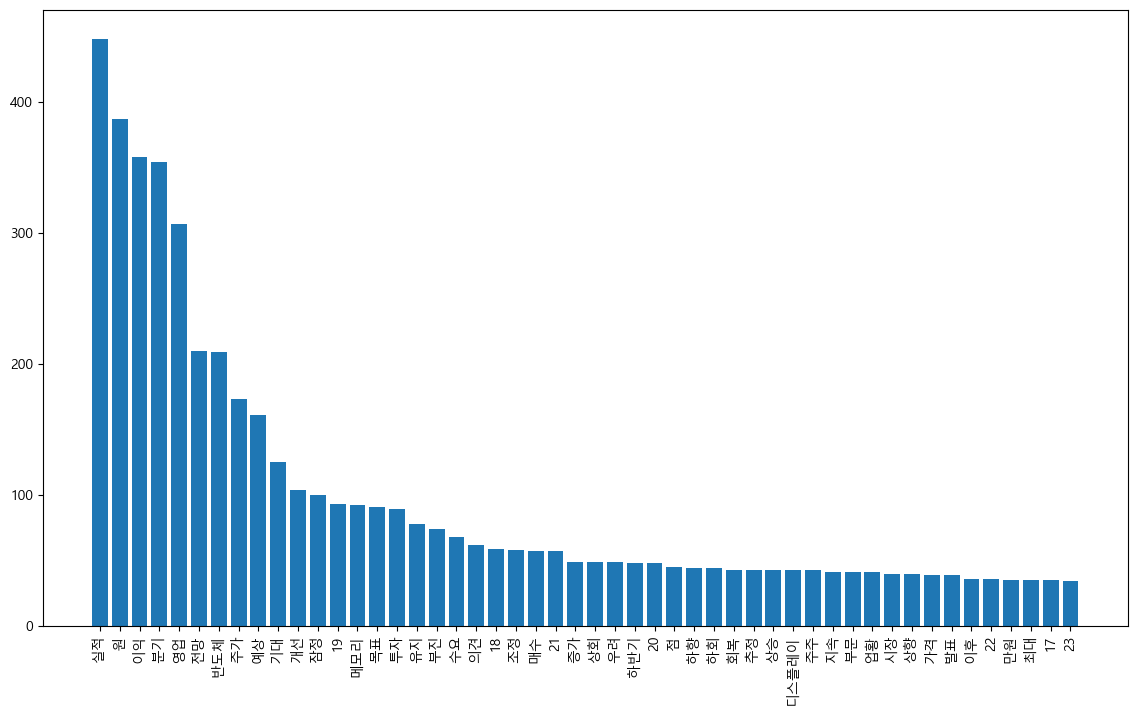

In [147]:
plt.figure(figsize=(14,8))

df_hankyung_consensus['제목_세부내용_전처리후_Komoran_명사'] = df_hankyung_consensus['제목_세부내용_전처리후_Komoran_명사'].astype(str)

# 단어 빈도 계산
word_counts = Counter(' '.join(df_hankyung_consensus['제목_세부내용_전처리후_Komoran_명사']).split())

# 상위 20개 단어 시각화
common_words  = word_counts.most_common()[0:50]  # 21번째에서 40번째 단어
words, counts = zip(*common_words)

plt.bar(words, counts)
plt.xticks(rotation=90)
plt.show()

2014년도 데이터에 특수문자가 있어 아래와 같이 예외코드 추가

In [151]:
df_hankyung_consensus[['작성일','평가의견']

,작성일,평가의견,제목_세부내용_전처리후
0,2024-08-07 00:00:00,Buy,추세 하락 이전에 주가 반등 가능할 듯
1,2024-08-01 00:00:00,Buy,여전히 강력한 AI발 수요 조정기를 거치며 더욱 편해진 주가 여전히 강력한 AI발 ...
2,2024-08-01 00:00:00,Buy,메모리반도체 수익성 개선 본격화
3,2024-08-01 00:00:00,Buy,HBM 경쟁 심화 예상
4,2024-08-01 00:00:00,Buy,TSMC와의 시가총액 격차를 좁혀나 갈 시간
...,...,...,...
1008,2017-09-11 00:00:00,Buy,3Q17 영업이익 총 15조원 반도체 10조원 전망 3Q17 영업이익 15조원 시장...
1009,2017-09-08 00:00:00,Buy,실적 성장 재개와 함께 강화되는 주주환원 시장 기대치를 소폭 능가하는 3Q17 영업...
1010,2017-09-08 00:00:00,Buy,3분기 증익을 예상합니다 3분기 영업이익 14.3조원 전망
1011,2017-09-08 00:00:00,Buy,3분기 감익 우려 해소 기대 4분기 서프라이즈 실적 기대


In [79]:
# 특수 문자를 제거하는 함수 정의
def remove_illegal_characters(value):
    if isinstance(value, str):
        # ASCII 제어 문자(0x00~0x1F 및 0x7F)를 모두 제거
        return re.sub(r'[\x00-\x1F\x7F]', '', value)
    return value

# 데이터프레임의 모든 셀에 대해 함수 적용
def clean_illegal_characters(df):
    return df.apply(lambda col: col.map(remove_illegal_characters))

# 데이터프레임을 정리합니다.
df_hankyung_consensus_cleaned = clean_illegal_characters(df_hankyung_consensus)

애널리스트 평가의견을 감정분석 3 level에 맞게 매핑

In [81]:
opinion_mapping = {
     'BUY':1
    ,'시장평균':0
    ,'매수':1
    ,'HOLD':0
    ,'장기매수':1
    ,'중립':0
    ,'MKTPER':0
    ,'OUTPERFORM':1
    ,'TRADINGBUY':1
    ,'적극매수':1
    ,'보유':0
    ,'비중축소':-1
    ,'MARKETPERFORM':0
    ,'UNDERPERFORM':-1
    ,'-':0
    ,'STRONGBUY':1
    ,'SELL':-1
    ,'매도':-1
    ,'mktper':0
    ,'MKTPERFORM':0
    ,'buy':1
    ,'강력매수':1
    ,'NEUTRAL':0
    ,'MKTPERF':0
    ,'MKTUNDERPERF':-1
    ,'OUTPER':1
    ,'Buy':1
    ,'NotRated':0
    ,'Hold':0
    ,'TradingBuy':1
    ,'marketperform':0
    ,'StrongBuy':1
    ,'Reduce':-1
    ,'nan':0
    ,'nr':0
    ,'축소':-1
    ,'REDUCE':-1
    ,'비중확대':1
    ,'시장수익률':0
    ,'Sell':-1
    ,'underperform':-1
    ,'neutral':0
    ,'Outperform':1
    ,'SUSPENDED':0
    ,'Neutral':0
    ,'na':0
    ,'투자의견없음':0
    ,'':0
}

# 평가의견을 레이블로 매핑하여 새로운 컬럼 생성
df_hankyung_consensus_cleaned['평가의견_label'] = df_hankyung_consensus_cleaned['평가의견'].map(opinion_mapping)

# 평가의견_label이 없는 경우 기본값으로 채우기 (중립인 0로 채우기)
df_hankyung_consensus_cleaned['평가의견_label'] = df_hankyung_consensus_cleaned['평가의견_label'].fillna(0)

In [82]:
# '세부내용_전처리후' 열이 빈 문자열이거나 NaN인 행을 제거
df_hankyung_consensus_cleaned = df_hankyung_consensus_cleaned[df_hankyung_consensus_cleaned['제목_세부내용_전처리후'].str.strip() != '']

In [83]:
df_hankyung_consensus_cleaned # 955=>947개로

,작성일,종목명,종목코드,제목,적정가격,평가의견,작성자,작성기관,세부내용,세부내용_전처리후,제목_세부내용_전처리후,제목_세부내용_전처리후_Okt,제목_세부내용_전처리후_Hannanum,제목_세부내용_전처리후_Kkma,제목_세부내용_전처리후_Komoran,제목_세부내용_전처리후_kiwi,제목_세부내용_전처리후_Komoran_명사,평가의견_label
0,2024-08-07,삼성전자,005930,추세 하락 이전에 주가 반등 가능할 듯,"87,000",Buy,송명섭,하이투자증권,삼성전자(005930) 추세 하락 이전에 주가 반등 가능할 듯추세 하락 이전에 주가...,,추세 하락 이전에 주가 반등 가능할 듯,추세 하락 이전 주가 반등 가능할 듯,추세 하락 이전 주 반등 가능 ㄹ 듯,추세 하락 이전 주가 반등 가능 ㄹ 듯,추세 하락 이전 주가 반등 가능 ㄹ 듯,추세 하락 이전 주가 반등 가능,추세 하락 이전 주가 반등 듯,1.0
1,2024-08-01,삼성전자,005930,여전히 강력한 AI발 수요 조정기를 거치며 더욱 편해진 주가,"115,000",Buy,"김광진,최영주",한화투자증권,삼성전자(005930) 여전히 강력한 AI발 수요. 조정기를 거치며 더욱 편해진 주...,여전히 강력한 AI발 수요. 조정기를 거치며 더욱 편해진 주가여전히 강력한 AI발...,여전히 강력한 AI발 수요 조정기를 거치며 더욱 편해진 주가 여전히 강력한 AI발 ...,강력한 AI 발 수요 조 정기 거치 며 더욱 편해진 주가 강력한 AI 발 수요 조 ...,강력 ㄴ AI 발 수요 조정기 거치 며 더욱 편하 지 ㄴ 주 강력 ㄴ AI 발 수요...,강력 ㄴ AI 발 수요 조정기 거치 며 더욱 펴 ㄴ 해진 주가 강력 ㄴ AI 발 수...,강력 ㄴ AI 발 수요 조정 기 거치 며 더욱 편 해진 주가 강력 ㄴ AI 발 수요...,AI 수요 조정기 편하 AI 수요 조정기 편하 AI 수요 조정기 편하 주가,발 수요 조정 편 해진 주가 발 수요 조정 편 해진 주가 발 수요 조정 편 해진 주가,1.0
2,2024-08-01,삼성전자,005930,메모리반도체 수익성 개선 본격화,"110,000",Buy,백길현,유안타증권,삼성전자(005930) 메모리반도체 수익성 개선 본격화메모리반도체 수익성 개선 본격화,,메모리반도체 수익성 개선 본격화,메모리 반도체 수익 성 개선 본격 화,메모리반도체 수익성 개 선 본격화,메모리 반도체 수익성 개선 본격화,메모리 반도체 수익 성 개선 본격 화,메모리 반도체 수익 개선 본격,메모리 반도체 수익 개선,1.0
3,2024-08-01,삼성전자,005930,HBM 경쟁 심화 예상,"97,000",Buy,"송명섭,손우성",하이투자증권,삼성전자(005930) HBM 경쟁 심화 예상HBM 경쟁 심화 예상,,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,경쟁 심화 예상,1.0
4,2024-08-01,삼성전자,005930,TSMC와의 시가총액 격차를 좁혀나 갈 시간,"110,000",Buy,이승우,유진투자증권,삼성전자(005930) TSMC와의 시가총액 격차를 좁혀나 갈 시간TSMC와의 시가...,,TSMC와의 시가총액 격차를 좁혀나 갈 시간,TSMC 와의 시가총액 격차 좁혀나 갈,TSMC 와의 시가총액 격차 좁히 ㄹ,TSMC 와의 시가 총액 격차 좁히 ㄹ,TSMC 시가총액 격차 좁히 ㄹ,TSMC 시가 총액 격차,시가총액 격차,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1008,2017-09-11,삼성전자,005930,3Q17 영업이익 총 15조원 반도체 10조원 전망,"3,100,000",Buy,박유악,키움증권,"삼성전자(005930)3Q17 영업이익 총 15조원, 반도체 10조원 전망3Q17 ...",3Q17 영업이익 15조원 시장 기대치 상회할 전망,3Q17 영업이익 총 15조원 반도체 10조원 전망 3Q17 영업이익 15조원 시장...,3 Q 17 영업 이익 총 15조원 반도체 10조원 전망 3 Q 17 영업 이익 1...,3Q17 영업이익 총 15조원 반도체 10조원 전망 3Q17 영업이익 15조원 시장...,3 Q 17 영업 이익 총 15 조 원 반도체 10 조 원 전망 3 Q 17 영업 ...,3 Q 17 영업 이익 총 15 조 원 반도체 10 조 원 전망 3 Q 17 영업 ...,17 영업 이익 15 반도체 10 전망 17 영업 이익 15 시장 기대치 상회 전망,17 영업 이익 원 반도체 원 전망 17 영업 이익 원 시장 기대 상회 전망,1.0
1009,2017-09-08,삼성전자,005930,실적 성장 재개와 함께 강화되는 주주환원,"3,040,000",Buy,김선우,메리츠종금증권,삼성전자(005930)실적 성장 재개와 함께 강화되는 주주환원시장 기대치를 소폭 능...,시장 기대치를 소폭 능가하는 3Q17 영업이익 14.3조원 전망 지속 유지 4Q1...,실적 성장 재개와 함께 강화되는 주주환원 시장 기대치를 소폭 능가하는 3Q17 영업...,실적 성장 재개 강화 되는 주주 환원 시장 기 대치 소 폭 능가 하는 3 Q 17 ...,실적 성장 재개 강화 되 는 주주환원 시장 기대치 소폭 능가 는 3Q17 영업이익 ...,실적 성장 재개 강화 되 는 주주 환원 시장 기대치 소폭 능가 는 3 Q 17 영업...,실적 성장 재개 강화 되 는 주주 환원 시장 기대치 소폭 능가 는 3 Q 17 영업...,실적 성장 재개 강화 주주 환원 시장 기대치 소폭 능가 17 영업 이익 14.3 전...,실적 성장 재개 강화 주주 환원 시장 기대치 소폭 능가 17 영업 이익 원 전망 지...,1.0
1010,2017-09-08,삼성전자,005930,3분기 증익을 예상합니다,"3,300,000",Buy,어규진,이베스트증권,삼성전자(005930)3분기 증익을 예상합니다!3분기 영업이익 14.3조원 전망,3분기 영업이익 14.3조원 전망,3분기 증익을 예상합니다 3분기 영업이익 14.3조원 전망,3분 기 증익 예상 합니다 3분 기 영업 이익 14.3조원 전망,3분기 증익 예상 ㅂ니다 3분기 영업이익 14. 3조원 전망,3 분기 증익 예상 ㅂ니다 3 분기 영업 이익 14.3 조 원 전망,3 분기 증 익 예상 ㅂ니다 3 분기 영업 이익 14 3 조 원 전망,분기 예상 분기 영업 이익 14.3 전망,분기 증 익 예상 분기 영업 이익 원 전망,1.0
1011,2017-09-08,삼성전자,005930,3분기 감익 우려 해소 기대,"3,100,000",Buy,"이순학,김정현",한화투자증권,삼성전자(005930)3분기 감익 우려 해소 기대4분기 서프라이즈 실적 기대,4분기 서프라이즈 실적 기대,3분기 감익 우려 해소 기대 4분기 서프라이즈 실적 기대,3분 기 감익 우려 해소 기대 4분 기 서프라이즈 실적 기대,3분기 감익 우려 해소 기대 4분기 서프라이즈 실적 기대,3 분기 감익 우려 해소 기대 4 분기 서 프라이 즈 실적 기대,3 분기 감 익 우려 해소 기대 4 분기 서프라이즈 실적 기대,분기 우려 해소 기대 분기 서프라이즈 실적 기대,분기 감 익 우려 해소 기대 분기 서프라이즈 실적 기대,1.0


In [84]:
df_hankyung_consensus_cleaned = df_hankyung_consensus_cleaned.sort_values(by=['작성일', '작성기관'])

In [85]:
df_hankyung_consensus_cleaned.to_excel("./Text_Data/한경_리포트_데이터_기업_SEC.xlsx", index=False)

In [86]:
df_hankyung_consensus_cleaned 

,작성일,종목명,종목코드,제목,적정가격,평가의견,작성자,작성기관,세부내용,세부내용_전처리후,제목_세부내용_전처리후,제목_세부내용_전처리후_Okt,제목_세부내용_전처리후_Hannanum,제목_세부내용_전처리후_Kkma,제목_세부내용_전처리후_Komoran,제목_세부내용_전처리후_kiwi,제목_세부내용_전처리후_Komoran_명사,평가의견_label
1012,2017-09-06,삼성전자,005930,조정의 빌미는 사라지고 있나,"2,800,000",Buy,황민성,삼성증권,삼성전자(005930)조정의 빌미는 사라지고 있나?반도체 혁신으로 메모리 반도체 제...,반도체 혁신으로 메모리 반도체 제값 받기는 진행 중. 매수의견과 목표가 280만...,조정의 빌미는 사라지고 있나 반도체 혁신으로 메모리 반도체 제값 받기는 진행 중. ...,조정 빌 미는 사라지고 있나 반도체 혁신 메모리 반도체 값 받기는 진행 중 수 의견...,조정 빌미 는 사라지 고 있 반도체 혁신 메모리 반도체 제값 받 기 는 진행 중 매...,조정 빌미 는 사라지 고 있 반 도 체 혁신 메모리 반도체 제값 받 기 는 진행 중...,조정 빌미 는 사라지 고 있 반도체 혁신 메모리 반도체 제값 받 기 는 진행 중 매...,조정 빌미 반도체 혁신 메모리 반도체 제값 진행 매수 의견 목표 280 유지,조정 빌미 반도체 혁신 메모리 반도체 제값 진행 중 매수 의견 목표 만원 유지,1.0
1009,2017-09-08,삼성전자,005930,실적 성장 재개와 함께 강화되는 주주환원,"3,040,000",Buy,김선우,메리츠종금증권,삼성전자(005930)실적 성장 재개와 함께 강화되는 주주환원시장 기대치를 소폭 능...,시장 기대치를 소폭 능가하는 3Q17 영업이익 14.3조원 전망 지속 유지 4Q1...,실적 성장 재개와 함께 강화되는 주주환원 시장 기대치를 소폭 능가하는 3Q17 영업...,실적 성장 재개 강화 되는 주주 환원 시장 기 대치 소 폭 능가 하는 3 Q 17 ...,실적 성장 재개 강화 되 는 주주환원 시장 기대치 소폭 능가 는 3Q17 영업이익 ...,실적 성장 재개 강화 되 는 주주 환원 시장 기대치 소폭 능가 는 3 Q 17 영업...,실적 성장 재개 강화 되 는 주주 환원 시장 기대치 소폭 능가 는 3 Q 17 영업...,실적 성장 재개 강화 주주 환원 시장 기대치 소폭 능가 17 영업 이익 14.3 전...,실적 성장 재개 강화 주주 환원 시장 기대치 소폭 능가 17 영업 이익 원 전망 지...,1.0
1010,2017-09-08,삼성전자,005930,3분기 증익을 예상합니다,"3,300,000",Buy,어규진,이베스트증권,삼성전자(005930)3분기 증익을 예상합니다!3분기 영업이익 14.3조원 전망,3분기 영업이익 14.3조원 전망,3분기 증익을 예상합니다 3분기 영업이익 14.3조원 전망,3분 기 증익 예상 합니다 3분 기 영업 이익 14.3조원 전망,3분기 증익 예상 ㅂ니다 3분기 영업이익 14. 3조원 전망,3 분기 증익 예상 ㅂ니다 3 분기 영업 이익 14.3 조 원 전망,3 분기 증 익 예상 ㅂ니다 3 분기 영업 이익 14 3 조 원 전망,분기 예상 분기 영업 이익 14.3 전망,분기 증 익 예상 분기 영업 이익 원 전망,1.0
1011,2017-09-08,삼성전자,005930,3분기 감익 우려 해소 기대,"3,100,000",Buy,"이순학,김정현",한화투자증권,삼성전자(005930)3분기 감익 우려 해소 기대4분기 서프라이즈 실적 기대,4분기 서프라이즈 실적 기대,3분기 감익 우려 해소 기대 4분기 서프라이즈 실적 기대,3분 기 감익 우려 해소 기대 4분 기 서프라이즈 실적 기대,3분기 감익 우려 해소 기대 4분기 서프라이즈 실적 기대,3 분기 감익 우려 해소 기대 4 분기 서 프라이 즈 실적 기대,3 분기 감 익 우려 해소 기대 4 분기 서프라이즈 실적 기대,분기 우려 해소 기대 분기 서프라이즈 실적 기대,분기 감 익 우려 해소 기대 분기 서프라이즈 실적 기대,1.0
1008,2017-09-11,삼성전자,005930,3Q17 영업이익 총 15조원 반도체 10조원 전망,"3,100,000",Buy,박유악,키움증권,"삼성전자(005930)3Q17 영업이익 총 15조원, 반도체 10조원 전망3Q17 ...",3Q17 영업이익 15조원 시장 기대치 상회할 전망,3Q17 영업이익 총 15조원 반도체 10조원 전망 3Q17 영업이익 15조원 시장...,3 Q 17 영업 이익 총 15조원 반도체 10조원 전망 3 Q 17 영업 이익 1...,3Q17 영업이익 총 15조원 반도체 10조원 전망 3Q17 영업이익 15조원 시장...,3 Q 17 영업 이익 총 15 조 원 반도체 10 조 원 전망 3 Q 17 영업 ...,3 Q 17 영업 이익 총 15 조 원 반도체 10 조 원 전망 3 Q 17 영업 ...,17 영업 이익 15 반도체 10 전망 17 영업 이익 15 시장 기대치 상회 전망,17 영업 이익 원 반도체 원 전망 17 영업 이익 원 시장 기대 상회 전망,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,2024-08-01,삼성전자,005930,메모리반도체 수익성 개선 본격화,"110,000",Buy,백길현,유안타증권,삼성전자(005930) 메모리반도체 수익성 개선 본격화메모리반도체 수익성 개선 본격화,,메모리반도체 수익성 개선 본격화,메모리 반도체 수익 성 개선 본격 화,메모리반도체 수익성 개 선 본격화,메모리 반도체 수익성 개선 본격화,메모리 반도체 수익 성 개선 본격 화,메모리 반도체 수익 개선 본격,메모리 반도체 수익 개선,1.0
4,2024-08-01,삼성전자,005930,TSMC와의 시가총액 격차를 좁혀나 갈 시간,"110,000",Buy,이승우,유진투자증권,삼성전자(005930) TSMC와의 시가총액 격차를 좁혀나 갈 시간TSMC와의 시가...,,TSMC와의 시가총액 격차를 좁혀나 갈 시간,TSMC 와의 시가총액 격차 좁혀나 갈,TSMC 와의 시가총액 격차 좁히 ㄹ,TSMC 와의 시가 총액 격차 좁히 ㄹ,TSMC 시가총액 격차 좁히 ㄹ,TSMC 시가 총액 격차,시가총액 격차,1.0
3,2024-08-01,삼성전자,005930,HBM 경쟁 심화 예상,"97,000",Buy,"송명섭,손우성",하이투자증권,삼성전자(005930) HBM 경쟁 심화 예상HBM 경쟁 심화 예상,,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,경쟁 심화 예상,1.0
1,2024-08-01,삼성전자,005930,여전히 강력한 AI발 수요 조정기를 거치며 더욱 편해진 주가,"115,000",Buy,"김광진,최영주",한화투자증권,삼성전자(005930) 여전히 강력한 AI발 수요. 조정기를 거치며 더욱 편해진 주...,여전히 강력한 AI발 수요. 조정기를 거치며 더욱 편해진 주가여전히 강력한 AI발...,여전히 강력한 AI발 수요 조정기를 거치며 더욱 편해진 주가 여전히 강력한 AI발 ...,강력한 AI 발 수요 조 정기 거치 며 더욱 편해진 주가 강력한 AI 발 수요 조 ...,강력 ㄴ AI 발 수요 조정기 거치 며 더욱 편하 지 ㄴ 주 강력 ㄴ AI 발 수요...,강력 ㄴ AI 발 수요 조정기 거치 며 더욱 펴 ㄴ 해진 주가 강력 ㄴ AI 발 수...,강력 ㄴ AI 발 수요 조정 기 거치 며 더욱 편 해진 주가 강력 ㄴ AI 발 수요...,AI 수요 조정기 편하 AI 수요 조정기 편하 AI 수요 조정기 편하 주가,발 수요 조정 편 해진 주가 발 수요 조정 편 해진 주가 발 수요 조정 편 해진 주가,1.0


In [89]:
# 엑셀 파일 목록
# files = [
#     './Text_Data/한경_리포트_데이터_기업_2002.xlsx',
#     './Text_Data/한경_리포트_데이터_기업_2003.xlsx',
#     './Text_Data/한경_리포트_데이터_기업_2004.xlsx',
#     './Text_Data/한경_리포트_데이터_기업_2005.xlsx',
#     './Text_Data/한경_리포트_데이터_기업_2006.xlsx',
#     './Text_Data/한경_리포트_데이터_기업_2007.xlsx',
#     './Text_Data/한경_리포트_데이터_기업_2008.xlsx',
#     './Text_Data/한경_리포트_데이터_기업_2009.xlsx',
#     './Text_Data/한경_리포트_데이터_기업_2010.xlsx',
#     './Text_Data/한경_리포트_데이터_기업_2011.xlsx',
#     './Text_Data/한경_리포트_데이터_기업_2012.xlsx',
#     './Text_Data/한경_리포트_데이터_기업_2013.xlsx',
#     './Text_Data/한경_리포트_데이터_기업_2014.xlsx',
#     './Text_Data/한경_리포트_데이터_기업_2015.xlsx',
#     './Text_Data/한경_리포트_데이터_기업_2016.xlsx',
#     './Text_Data/한경_리포트_데이터_기업_2017.xlsx',
#     './Text_Data/한경_리포트_데이터_기업_2018.xlsx',
#     './Text_Data/한경_리포트_데이터_기업_2019.xlsx',
#     './Text_Data/한경_리포트_데이터_기업_2020.xlsx',
#     './Text_Data/한경_리포트_데이터_기업_2021.xlsx',
#     './Text_Data/한경_리포트_데이터_기업_2022.xlsx',
#     './Text_Data/한경_리포트_데이터_기업_2023.xlsx',
#     './Text_Data/한경_리포트_데이터_기업_2024.xlsx'
# ]

# # 데이터를 읽을 때 종목코드 열을 문자열로 읽어오도록 설정
# df_excel = [pd.read_excel(file, dtype={'종목코드': str}) for file in files]

# # 모든 데이터프레임을 하나로 병합
# df_merge = pd.concat(df_excel, ignore_index=True)

# # 병합된 데이터프레임을 새로운 엑셀 파일로 저장
# df_merge.to_excel('./Text_Data/한경_리포트_데이터_기업.xlsx', index=False)

In [91]:
df_hankyung_consensus = pd.read_excel('./Text_Data/한경_리포트_데이터_기업_SEC.xlsx')

In [92]:
df_hankyung_consensus.columns

Index(['작성일', '종목명', '종목코드', '제목', '적정가격', '평가의견', '작성자', '작성기관', '세부내용',
       '세부내용_전처리후', '제목_세부내용_전처리후', '제목_세부내용_전처리후_Okt',
       '제목_세부내용_전처리후_Hannanum', '제목_세부내용_전처리후_Kkma', '제목_세부내용_전처리후_Komoran',
       '제목_세부내용_전처리후_kiwi', '제목_세부내용_전처리후_Komoran_명사', '평가의견_label'],
      dtype='object')

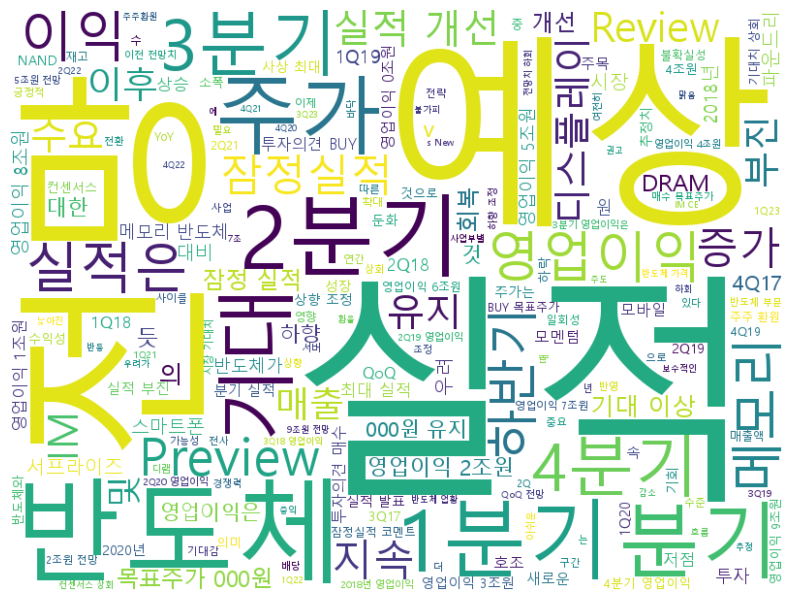

In [93]:
# 제목과 세부내용 전처리 후 텍스트를 모두 하나의 문자열로 결합
text_data = " ".join(df_hankyung_consensus['제목_세부내용_전처리후'].dropna())

# 워드클라우드 생성
wordcloud = WordCloud(
    font_path='C:/Windows/Fonts/malgun.ttf', # 한글 폰트 설정 (Windows에서 한글 폰트 경로를 지정)
    background_color='white',
    width=800,
    height=600
).generate(text_data)

# 워드클라우드 시각화
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 축을 숨김
plt.show()

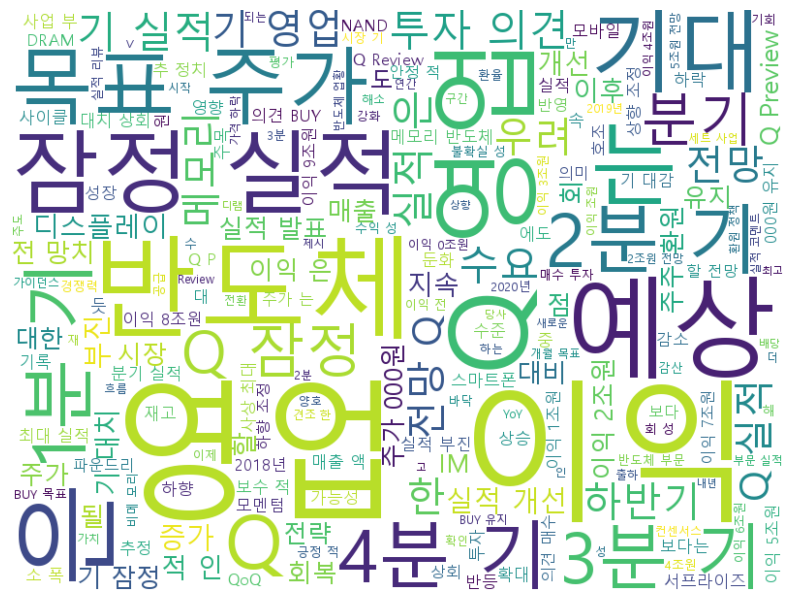

In [94]:
# 제목과 세부내용 전처리 후 텍스트를 모두 하나의 문자열로 결합
text_data = " ".join(df_hankyung_consensus['제목_세부내용_전처리후_Okt'].dropna())

# 워드클라우드 생성
wordcloud = WordCloud(
    font_path='C:/Windows/Fonts/malgun.ttf', # 한글 폰트 설정 (Windows에서 한글 폰트 경로를 지정)
    background_color='white',
    width=800,
    height=600
).generate(text_data)

# 워드클라우드 시각화
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 축을 숨김
plt.show()

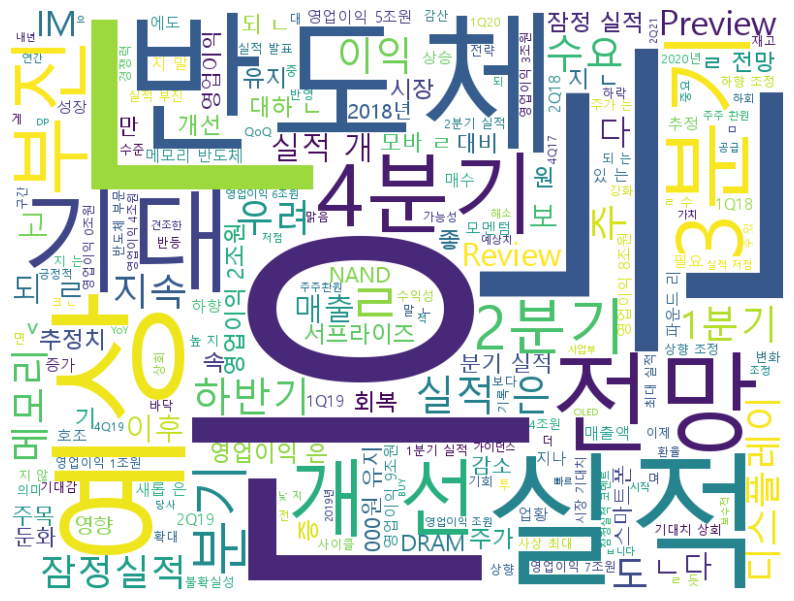

In [95]:
# 제목과 세부내용 전처리 후 텍스트를 모두 하나의 문자열로 결합
text_data = " ".join(df_hankyung_consensus['제목_세부내용_전처리후_Hannanum'].dropna())

# 워드클라우드 생성
wordcloud = WordCloud(
    font_path='C:/Windows/Fonts/malgun.ttf', # 한글 폰트 설정 (Windows에서 한글 폰트 경로를 지정)
    background_color='white',
    width=800,
    height=600
).generate(text_data)

# 워드클라우드 시각화
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 축을 숨김
plt.show()

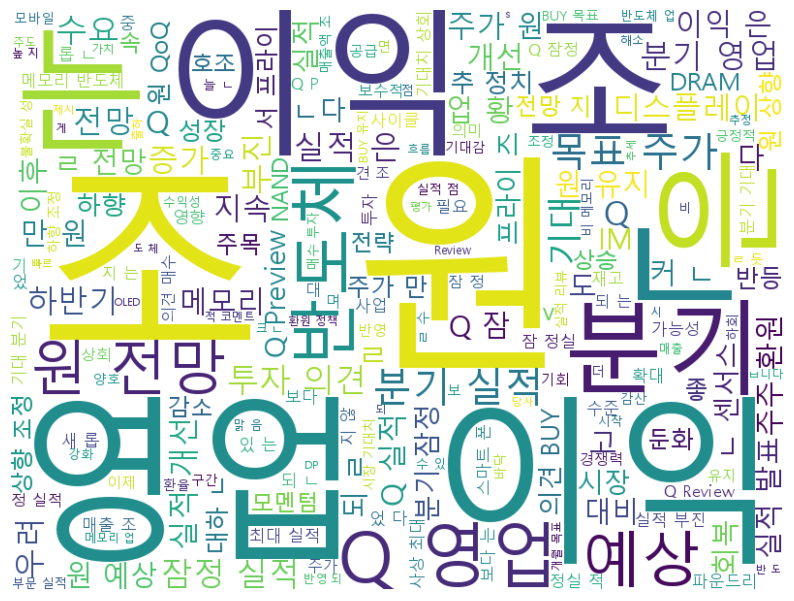

In [96]:
# 제목과 세부내용 전처리 후 텍스트를 모두 하나의 문자열로 결합
text_data = " ".join(df_hankyung_consensus['제목_세부내용_전처리후_Kkma'].dropna())

# 워드클라우드 생성
wordcloud = WordCloud(
    font_path='C:/Windows/Fonts/malgun.ttf', # 한글 폰트 설정 (Windows에서 한글 폰트 경로를 지정)
    background_color='white',
    width=800,
    height=600
).generate(text_data)

# 워드클라우드 시각화
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 축을 숨김
plt.show()

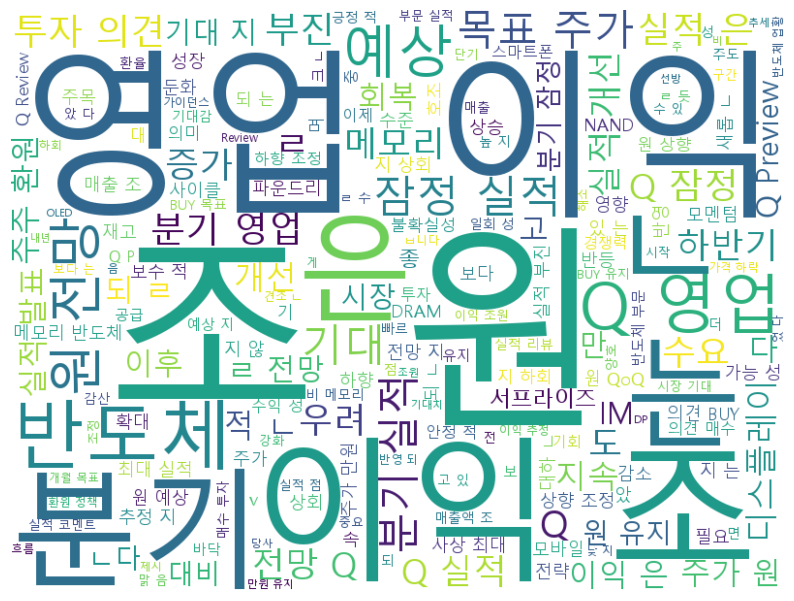

In [97]:
# 제목과 세부내용 전처리 후 텍스트를 모두 하나의 문자열로 결합
text_data = " ".join(df_hankyung_consensus['제목_세부내용_전처리후_Komoran'].dropna())

# 워드클라우드 생성
wordcloud = WordCloud(
    font_path='C:/Windows/Fonts/malgun.ttf', # 한글 폰트 설정 (Windows에서 한글 폰트 경로를 지정)
    background_color='white',
    width=800,
    height=600
).generate(text_data)

# 워드클라우드 시각화
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 축을 숨김
plt.show()

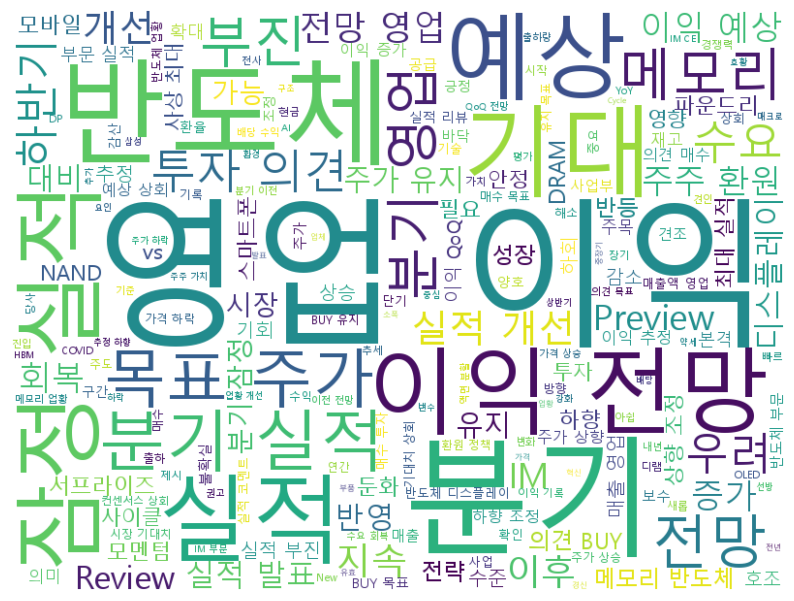

In [98]:
# 제목과 세부내용 전처리 후 텍스트를 모두 하나의 문자열로 결합
text_data = " ".join(df_hankyung_consensus['제목_세부내용_전처리후_kiwi'].dropna())

# 워드클라우드 생성
wordcloud = WordCloud(
    font_path='C:/Windows/Fonts/malgun.ttf', # 한글 폰트 설정 (Windows에서 한글 폰트 경로를 지정)
    background_color='white',
    width=800,
    height=600
).generate(text_data)

# 워드클라우드 시각화
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 축을 숨김
plt.show()

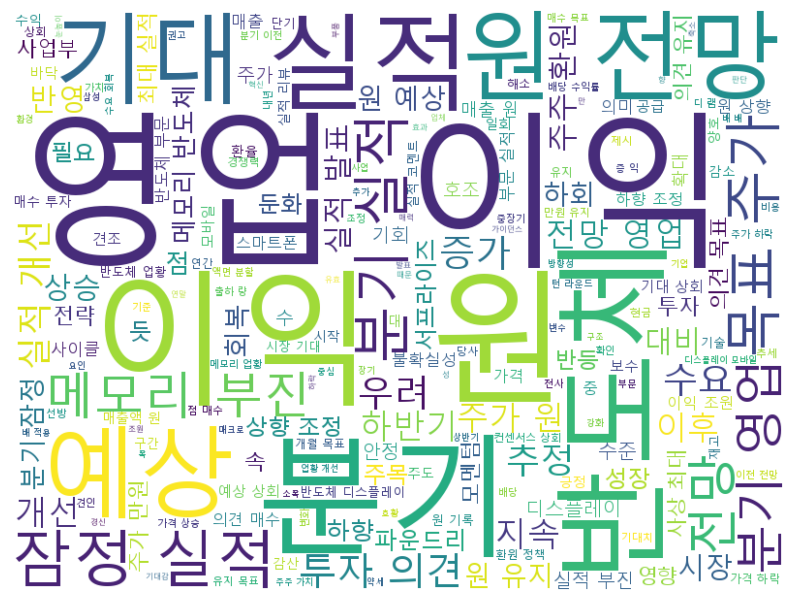

In [100]:
# 제목과 세부내용 전처리 후 텍스트를 모두 하나의 문자열로 결합
text_data = " ".join(df_hankyung_consensus['제목_세부내용_전처리후_Komoran_명사'].dropna())

# 워드클라우드 생성
wordcloud = WordCloud(
    font_path='C:/Windows/Fonts/malgun.ttf', # 한글 폰트 설정 (Windows에서 한글 폰트 경로를 지정)
    background_color='white',
    width=800,
    height=600
).generate(text_data)

# 워드클라우드 시각화
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 축을 숨김
plt.show()

In [102]:
df_hankyung_consensus

,작성일,종목명,종목코드,제목,적정가격,평가의견,작성자,작성기관,세부내용,세부내용_전처리후,제목_세부내용_전처리후,제목_세부내용_전처리후_Okt,제목_세부내용_전처리후_Hannanum,제목_세부내용_전처리후_Kkma,제목_세부내용_전처리후_Komoran,제목_세부내용_전처리후_kiwi,제목_세부내용_전처리후_Komoran_명사,평가의견_label
0,2017-09-06,삼성전자,5930,조정의 빌미는 사라지고 있나,"2,800,000",Buy,황민성,삼성증권,삼성전자(005930)조정의 빌미는 사라지고 있나?반도체 혁신으로 메모리 반도체 제...,반도체 혁신으로 메모리 반도체 제값 받기는 진행 중. 매수의견과 목표가 280만...,조정의 빌미는 사라지고 있나 반도체 혁신으로 메모리 반도체 제값 받기는 진행 중. ...,조정 빌 미는 사라지고 있나 반도체 혁신 메모리 반도체 값 받기는 진행 중 수 의견...,조정 빌미 는 사라지 고 있 반도체 혁신 메모리 반도체 제값 받 기 는 진행 중 매...,조정 빌미 는 사라지 고 있 반 도 체 혁신 메모리 반도체 제값 받 기 는 진행 중...,조정 빌미 는 사라지 고 있 반도체 혁신 메모리 반도체 제값 받 기 는 진행 중 매...,조정 빌미 반도체 혁신 메모리 반도체 제값 진행 매수 의견 목표 280 유지,조정 빌미 반도체 혁신 메모리 반도체 제값 진행 중 매수 의견 목표 만원 유지,1
1,2017-09-08,삼성전자,5930,실적 성장 재개와 함께 강화되는 주주환원,"3,040,000",Buy,김선우,메리츠종금증권,삼성전자(005930)실적 성장 재개와 함께 강화되는 주주환원시장 기대치를 소폭 능...,시장 기대치를 소폭 능가하는 3Q17 영업이익 14.3조원 전망 지속 유지 4Q1...,실적 성장 재개와 함께 강화되는 주주환원 시장 기대치를 소폭 능가하는 3Q17 영업...,실적 성장 재개 강화 되는 주주 환원 시장 기 대치 소 폭 능가 하는 3 Q 17 ...,실적 성장 재개 강화 되 는 주주환원 시장 기대치 소폭 능가 는 3Q17 영업이익 ...,실적 성장 재개 강화 되 는 주주 환원 시장 기대치 소폭 능가 는 3 Q 17 영업...,실적 성장 재개 강화 되 는 주주 환원 시장 기대치 소폭 능가 는 3 Q 17 영업...,실적 성장 재개 강화 주주 환원 시장 기대치 소폭 능가 17 영업 이익 14.3 전...,실적 성장 재개 강화 주주 환원 시장 기대치 소폭 능가 17 영업 이익 원 전망 지...,1
2,2017-09-08,삼성전자,5930,3분기 증익을 예상합니다,"3,300,000",Buy,어규진,이베스트증권,삼성전자(005930)3분기 증익을 예상합니다!3분기 영업이익 14.3조원 전망,3분기 영업이익 14.3조원 전망,3분기 증익을 예상합니다 3분기 영업이익 14.3조원 전망,3분 기 증익 예상 합니다 3분 기 영업 이익 14.3조원 전망,3분기 증익 예상 ㅂ니다 3분기 영업이익 14. 3조원 전망,3 분기 증익 예상 ㅂ니다 3 분기 영업 이익 14.3 조 원 전망,3 분기 증 익 예상 ㅂ니다 3 분기 영업 이익 14 3 조 원 전망,분기 예상 분기 영업 이익 14.3 전망,분기 증 익 예상 분기 영업 이익 원 전망,1
3,2017-09-08,삼성전자,5930,3분기 감익 우려 해소 기대,"3,100,000",Buy,"이순학,김정현",한화투자증권,삼성전자(005930)3분기 감익 우려 해소 기대4분기 서프라이즈 실적 기대,4분기 서프라이즈 실적 기대,3분기 감익 우려 해소 기대 4분기 서프라이즈 실적 기대,3분 기 감익 우려 해소 기대 4분 기 서프라이즈 실적 기대,3분기 감익 우려 해소 기대 4분기 서프라이즈 실적 기대,3 분기 감익 우려 해소 기대 4 분기 서 프라이 즈 실적 기대,3 분기 감 익 우려 해소 기대 4 분기 서프라이즈 실적 기대,분기 우려 해소 기대 분기 서프라이즈 실적 기대,분기 감 익 우려 해소 기대 분기 서프라이즈 실적 기대,1
4,2017-09-11,삼성전자,5930,3Q17 영업이익 총 15조원 반도체 10조원 전망,"3,100,000",Buy,박유악,키움증권,"삼성전자(005930)3Q17 영업이익 총 15조원, 반도체 10조원 전망3Q17 ...",3Q17 영업이익 15조원 시장 기대치 상회할 전망,3Q17 영업이익 총 15조원 반도체 10조원 전망 3Q17 영업이익 15조원 시장...,3 Q 17 영업 이익 총 15조원 반도체 10조원 전망 3 Q 17 영업 이익 1...,3Q17 영업이익 총 15조원 반도체 10조원 전망 3Q17 영업이익 15조원 시장...,3 Q 17 영업 이익 총 15 조 원 반도체 10 조 원 전망 3 Q 17 영업 ...,3 Q 17 영업 이익 총 15 조 원 반도체 10 조 원 전망 3 Q 17 영업 ...,17 영업 이익 15 반도체 10 전망 17 영업 이익 15 시장 기대치 상회 전망,17 영업 이익 원 반도체 원 전망 17 영업 이익 원 시장 기대 상회 전망,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942,2024-08-01,삼성전자,5930,메모리반도체 수익성 개선 본격화,"110,000",Buy,백길현,유안타증권,삼성전자(005930) 메모리반도체 수익성 개선 본격화메모리반도체 수익성 개선 본격화,,메모리반도체 수익성 개선 본격화,메모리 반도체 수익 성 개선 본격 화,메모리반도체 수익성 개 선 본격화,메모리 반도체 수익성 개선 본격화,메모리 반도체 수익 성 개선 본격 화,메모리 반도체 수익 개선 본격,메모리 반도체 수익 개선,1
943,2024-08-01,삼성전자,5930,TSMC와의 시가총액 격차를 좁혀나 갈 시간,"110,000",Buy,이승우,유진투자증권,삼성전자(005930) TSMC와의 시가총액 격차를 좁혀나 갈 시간TSMC와의 시가...,,TSMC와의 시가총액 격차를 좁혀나 갈 시간,TSMC 와의 시가총액 격차 좁혀나 갈,TSMC 와의 시가총액 격차 좁히 ㄹ,TSMC 와의 시가 총액 격차 좁히 ㄹ,TSMC 시가총액 격차 좁히 ㄹ,TSMC 시가 총액 격차,시가총액 격차,1
944,2024-08-01,삼성전자,5930,HBM 경쟁 심화 예상,"97,000",Buy,"송명섭,손우성",하이투자증권,삼성전자(005930) HBM 경쟁 심화 예상HBM 경쟁 심화 예상,,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,경쟁 심화 예상,1
945,2024-08-01,삼성전자,5930,여전히 강력한 AI발 수요 조정기를 거치며 더욱 편해진 주가,"115,000",Buy,"김광진,최영주",한화투자증권,삼성전자(005930) 여전히 강력한 AI발 수요. 조정기를 거치며 더욱 편해진 주...,여전히 강력한 AI발 수요. 조정기를 거치며 더욱 편해진 주가여전히 강력한 AI발...,여전히 강력한 AI발 수요 조정기를 거치며 더욱 편해진 주가 여전히 강력한 AI발 ...,강력한 AI 발 수요 조 정기 거치 며 더욱 편해진 주가 강력한 AI 발 수요 조 ...,강력 ㄴ AI 발 수요 조정기 거치 며 더욱 편하 지 ㄴ 주 강력 ㄴ AI 발 수요...,강력 ㄴ AI 발 수요 조정기 거치 며 더욱 펴 ㄴ 해진 주가 강력 ㄴ AI 발 수...,강력 ㄴ AI 발 수요 조정 기 거치 며 더욱 편 해진 주가 강력 ㄴ AI 발 수요...,AI 수요 조정기 편하 AI 수요 조정기 편하 AI 수요 조정기 편하 주가,발 수요 조정 편 해진 주가 발 수요 조정 편 해진 주가 발 수요 조정 편 해진 주가,1


In [104]:
df_hankyung_consensus

,작성일,종목명,종목코드,제목,적정가격,평가의견,작성자,작성기관,세부내용,세부내용_전처리후,제목_세부내용_전처리후,제목_세부내용_전처리후_Okt,제목_세부내용_전처리후_Hannanum,제목_세부내용_전처리후_Kkma,제목_세부내용_전처리후_Komoran,제목_세부내용_전처리후_kiwi,제목_세부내용_전처리후_Komoran_명사,평가의견_label
0,2017-09-06,삼성전자,5930,조정의 빌미는 사라지고 있나,"2,800,000",Buy,황민성,삼성증권,삼성전자(005930)조정의 빌미는 사라지고 있나?반도체 혁신으로 메모리 반도체 제...,반도체 혁신으로 메모리 반도체 제값 받기는 진행 중. 매수의견과 목표가 280만...,조정의 빌미는 사라지고 있나 반도체 혁신으로 메모리 반도체 제값 받기는 진행 중. ...,조정 빌 미는 사라지고 있나 반도체 혁신 메모리 반도체 값 받기는 진행 중 수 의견...,조정 빌미 는 사라지 고 있 반도체 혁신 메모리 반도체 제값 받 기 는 진행 중 매...,조정 빌미 는 사라지 고 있 반 도 체 혁신 메모리 반도체 제값 받 기 는 진행 중...,조정 빌미 는 사라지 고 있 반도체 혁신 메모리 반도체 제값 받 기 는 진행 중 매...,조정 빌미 반도체 혁신 메모리 반도체 제값 진행 매수 의견 목표 280 유지,조정 빌미 반도체 혁신 메모리 반도체 제값 진행 중 매수 의견 목표 만원 유지,1
1,2017-09-08,삼성전자,5930,실적 성장 재개와 함께 강화되는 주주환원,"3,040,000",Buy,김선우,메리츠종금증권,삼성전자(005930)실적 성장 재개와 함께 강화되는 주주환원시장 기대치를 소폭 능...,시장 기대치를 소폭 능가하는 3Q17 영업이익 14.3조원 전망 지속 유지 4Q1...,실적 성장 재개와 함께 강화되는 주주환원 시장 기대치를 소폭 능가하는 3Q17 영업...,실적 성장 재개 강화 되는 주주 환원 시장 기 대치 소 폭 능가 하는 3 Q 17 ...,실적 성장 재개 강화 되 는 주주환원 시장 기대치 소폭 능가 는 3Q17 영업이익 ...,실적 성장 재개 강화 되 는 주주 환원 시장 기대치 소폭 능가 는 3 Q 17 영업...,실적 성장 재개 강화 되 는 주주 환원 시장 기대치 소폭 능가 는 3 Q 17 영업...,실적 성장 재개 강화 주주 환원 시장 기대치 소폭 능가 17 영업 이익 14.3 전...,실적 성장 재개 강화 주주 환원 시장 기대치 소폭 능가 17 영업 이익 원 전망 지...,1
2,2017-09-08,삼성전자,5930,3분기 증익을 예상합니다,"3,300,000",Buy,어규진,이베스트증권,삼성전자(005930)3분기 증익을 예상합니다!3분기 영업이익 14.3조원 전망,3분기 영업이익 14.3조원 전망,3분기 증익을 예상합니다 3분기 영업이익 14.3조원 전망,3분 기 증익 예상 합니다 3분 기 영업 이익 14.3조원 전망,3분기 증익 예상 ㅂ니다 3분기 영업이익 14. 3조원 전망,3 분기 증익 예상 ㅂ니다 3 분기 영업 이익 14.3 조 원 전망,3 분기 증 익 예상 ㅂ니다 3 분기 영업 이익 14 3 조 원 전망,분기 예상 분기 영업 이익 14.3 전망,분기 증 익 예상 분기 영업 이익 원 전망,1
3,2017-09-08,삼성전자,5930,3분기 감익 우려 해소 기대,"3,100,000",Buy,"이순학,김정현",한화투자증권,삼성전자(005930)3분기 감익 우려 해소 기대4분기 서프라이즈 실적 기대,4분기 서프라이즈 실적 기대,3분기 감익 우려 해소 기대 4분기 서프라이즈 실적 기대,3분 기 감익 우려 해소 기대 4분 기 서프라이즈 실적 기대,3분기 감익 우려 해소 기대 4분기 서프라이즈 실적 기대,3 분기 감익 우려 해소 기대 4 분기 서 프라이 즈 실적 기대,3 분기 감 익 우려 해소 기대 4 분기 서프라이즈 실적 기대,분기 우려 해소 기대 분기 서프라이즈 실적 기대,분기 감 익 우려 해소 기대 분기 서프라이즈 실적 기대,1
4,2017-09-11,삼성전자,5930,3Q17 영업이익 총 15조원 반도체 10조원 전망,"3,100,000",Buy,박유악,키움증권,"삼성전자(005930)3Q17 영업이익 총 15조원, 반도체 10조원 전망3Q17 ...",3Q17 영업이익 15조원 시장 기대치 상회할 전망,3Q17 영업이익 총 15조원 반도체 10조원 전망 3Q17 영업이익 15조원 시장...,3 Q 17 영업 이익 총 15조원 반도체 10조원 전망 3 Q 17 영업 이익 1...,3Q17 영업이익 총 15조원 반도체 10조원 전망 3Q17 영업이익 15조원 시장...,3 Q 17 영업 이익 총 15 조 원 반도체 10 조 원 전망 3 Q 17 영업 ...,3 Q 17 영업 이익 총 15 조 원 반도체 10 조 원 전망 3 Q 17 영업 ...,17 영업 이익 15 반도체 10 전망 17 영업 이익 15 시장 기대치 상회 전망,17 영업 이익 원 반도체 원 전망 17 영업 이익 원 시장 기대 상회 전망,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942,2024-08-01,삼성전자,5930,메모리반도체 수익성 개선 본격화,"110,000",Buy,백길현,유안타증권,삼성전자(005930) 메모리반도체 수익성 개선 본격화메모리반도체 수익성 개선 본격화,,메모리반도체 수익성 개선 본격화,메모리 반도체 수익 성 개선 본격 화,메모리반도체 수익성 개 선 본격화,메모리 반도체 수익성 개선 본격화,메모리 반도체 수익 성 개선 본격 화,메모리 반도체 수익 개선 본격,메모리 반도체 수익 개선,1
943,2024-08-01,삼성전자,5930,TSMC와의 시가총액 격차를 좁혀나 갈 시간,"110,000",Buy,이승우,유진투자증권,삼성전자(005930) TSMC와의 시가총액 격차를 좁혀나 갈 시간TSMC와의 시가...,,TSMC와의 시가총액 격차를 좁혀나 갈 시간,TSMC 와의 시가총액 격차 좁혀나 갈,TSMC 와의 시가총액 격차 좁히 ㄹ,TSMC 와의 시가 총액 격차 좁히 ㄹ,TSMC 시가총액 격차 좁히 ㄹ,TSMC 시가 총액 격차,시가총액 격차,1
944,2024-08-01,삼성전자,5930,HBM 경쟁 심화 예상,"97,000",Buy,"송명섭,손우성",하이투자증권,삼성전자(005930) HBM 경쟁 심화 예상HBM 경쟁 심화 예상,,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,경쟁 심화 예상,1
945,2024-08-01,삼성전자,5930,여전히 강력한 AI발 수요 조정기를 거치며 더욱 편해진 주가,"115,000",Buy,"김광진,최영주",한화투자증권,삼성전자(005930) 여전히 강력한 AI발 수요. 조정기를 거치며 더욱 편해진 주...,여전히 강력한 AI발 수요. 조정기를 거치며 더욱 편해진 주가여전히 강력한 AI발...,여전히 강력한 AI발 수요 조정기를 거치며 더욱 편해진 주가 여전히 강력한 AI발 ...,강력한 AI 발 수요 조 정기 거치 며 더욱 편해진 주가 강력한 AI 발 수요 조 ...,강력 ㄴ AI 발 수요 조정기 거치 며 더욱 편하 지 ㄴ 주 강력 ㄴ AI 발 수요...,강력 ㄴ AI 발 수요 조정기 거치 며 더욱 펴 ㄴ 해진 주가 강력 ㄴ AI 발 수...,강력 ㄴ AI 발 수요 조정 기 거치 며 더욱 편 해진 주가 강력 ㄴ AI 발 수요...,AI 수요 조정기 편하 AI 수요 조정기 편하 AI 수요 조정기 편하 주가,발 수요 조정 편 해진 주가 발 수요 조정 편 해진 주가 발 수요 조정 편 해진 주가,1


In [105]:
df_hankyung_consensus

,작성일,종목명,종목코드,제목,적정가격,평가의견,작성자,작성기관,세부내용,세부내용_전처리후,제목_세부내용_전처리후,제목_세부내용_전처리후_Okt,제목_세부내용_전처리후_Hannanum,제목_세부내용_전처리후_Kkma,제목_세부내용_전처리후_Komoran,제목_세부내용_전처리후_kiwi,제목_세부내용_전처리후_Komoran_명사,평가의견_label
0,2017-09-06,삼성전자,5930,조정의 빌미는 사라지고 있나,"2,800,000",Buy,황민성,삼성증권,삼성전자(005930)조정의 빌미는 사라지고 있나?반도체 혁신으로 메모리 반도체 제...,반도체 혁신으로 메모리 반도체 제값 받기는 진행 중. 매수의견과 목표가 280만...,조정의 빌미는 사라지고 있나 반도체 혁신으로 메모리 반도체 제값 받기는 진행 중. ...,조정 빌 미는 사라지고 있나 반도체 혁신 메모리 반도체 값 받기는 진행 중 수 의견...,조정 빌미 는 사라지 고 있 반도체 혁신 메모리 반도체 제값 받 기 는 진행 중 매...,조정 빌미 는 사라지 고 있 반 도 체 혁신 메모리 반도체 제값 받 기 는 진행 중...,조정 빌미 는 사라지 고 있 반도체 혁신 메모리 반도체 제값 받 기 는 진행 중 매...,조정 빌미 반도체 혁신 메모리 반도체 제값 진행 매수 의견 목표 280 유지,조정 빌미 반도체 혁신 메모리 반도체 제값 진행 중 매수 의견 목표 만원 유지,1
1,2017-09-08,삼성전자,5930,실적 성장 재개와 함께 강화되는 주주환원,"3,040,000",Buy,김선우,메리츠종금증권,삼성전자(005930)실적 성장 재개와 함께 강화되는 주주환원시장 기대치를 소폭 능...,시장 기대치를 소폭 능가하는 3Q17 영업이익 14.3조원 전망 지속 유지 4Q1...,실적 성장 재개와 함께 강화되는 주주환원 시장 기대치를 소폭 능가하는 3Q17 영업...,실적 성장 재개 강화 되는 주주 환원 시장 기 대치 소 폭 능가 하는 3 Q 17 ...,실적 성장 재개 강화 되 는 주주환원 시장 기대치 소폭 능가 는 3Q17 영업이익 ...,실적 성장 재개 강화 되 는 주주 환원 시장 기대치 소폭 능가 는 3 Q 17 영업...,실적 성장 재개 강화 되 는 주주 환원 시장 기대치 소폭 능가 는 3 Q 17 영업...,실적 성장 재개 강화 주주 환원 시장 기대치 소폭 능가 17 영업 이익 14.3 전...,실적 성장 재개 강화 주주 환원 시장 기대치 소폭 능가 17 영업 이익 원 전망 지...,1
2,2017-09-08,삼성전자,5930,3분기 증익을 예상합니다,"3,300,000",Buy,어규진,이베스트증권,삼성전자(005930)3분기 증익을 예상합니다!3분기 영업이익 14.3조원 전망,3분기 영업이익 14.3조원 전망,3분기 증익을 예상합니다 3분기 영업이익 14.3조원 전망,3분 기 증익 예상 합니다 3분 기 영업 이익 14.3조원 전망,3분기 증익 예상 ㅂ니다 3분기 영업이익 14. 3조원 전망,3 분기 증익 예상 ㅂ니다 3 분기 영업 이익 14.3 조 원 전망,3 분기 증 익 예상 ㅂ니다 3 분기 영업 이익 14 3 조 원 전망,분기 예상 분기 영업 이익 14.3 전망,분기 증 익 예상 분기 영업 이익 원 전망,1
3,2017-09-08,삼성전자,5930,3분기 감익 우려 해소 기대,"3,100,000",Buy,"이순학,김정현",한화투자증권,삼성전자(005930)3분기 감익 우려 해소 기대4분기 서프라이즈 실적 기대,4분기 서프라이즈 실적 기대,3분기 감익 우려 해소 기대 4분기 서프라이즈 실적 기대,3분 기 감익 우려 해소 기대 4분 기 서프라이즈 실적 기대,3분기 감익 우려 해소 기대 4분기 서프라이즈 실적 기대,3 분기 감익 우려 해소 기대 4 분기 서 프라이 즈 실적 기대,3 분기 감 익 우려 해소 기대 4 분기 서프라이즈 실적 기대,분기 우려 해소 기대 분기 서프라이즈 실적 기대,분기 감 익 우려 해소 기대 분기 서프라이즈 실적 기대,1
4,2017-09-11,삼성전자,5930,3Q17 영업이익 총 15조원 반도체 10조원 전망,"3,100,000",Buy,박유악,키움증권,"삼성전자(005930)3Q17 영업이익 총 15조원, 반도체 10조원 전망3Q17 ...",3Q17 영업이익 15조원 시장 기대치 상회할 전망,3Q17 영업이익 총 15조원 반도체 10조원 전망 3Q17 영업이익 15조원 시장...,3 Q 17 영업 이익 총 15조원 반도체 10조원 전망 3 Q 17 영업 이익 1...,3Q17 영업이익 총 15조원 반도체 10조원 전망 3Q17 영업이익 15조원 시장...,3 Q 17 영업 이익 총 15 조 원 반도체 10 조 원 전망 3 Q 17 영업 ...,3 Q 17 영업 이익 총 15 조 원 반도체 10 조 원 전망 3 Q 17 영업 ...,17 영업 이익 15 반도체 10 전망 17 영업 이익 15 시장 기대치 상회 전망,17 영업 이익 원 반도체 원 전망 17 영업 이익 원 시장 기대 상회 전망,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942,2024-08-01,삼성전자,5930,메모리반도체 수익성 개선 본격화,"110,000",Buy,백길현,유안타증권,삼성전자(005930) 메모리반도체 수익성 개선 본격화메모리반도체 수익성 개선 본격화,,메모리반도체 수익성 개선 본격화,메모리 반도체 수익 성 개선 본격 화,메모리반도체 수익성 개 선 본격화,메모리 반도체 수익성 개선 본격화,메모리 반도체 수익 성 개선 본격 화,메모리 반도체 수익 개선 본격,메모리 반도체 수익 개선,1
943,2024-08-01,삼성전자,5930,TSMC와의 시가총액 격차를 좁혀나 갈 시간,"110,000",Buy,이승우,유진투자증권,삼성전자(005930) TSMC와의 시가총액 격차를 좁혀나 갈 시간TSMC와의 시가...,,TSMC와의 시가총액 격차를 좁혀나 갈 시간,TSMC 와의 시가총액 격차 좁혀나 갈,TSMC 와의 시가총액 격차 좁히 ㄹ,TSMC 와의 시가 총액 격차 좁히 ㄹ,TSMC 시가총액 격차 좁히 ㄹ,TSMC 시가 총액 격차,시가총액 격차,1
944,2024-08-01,삼성전자,5930,HBM 경쟁 심화 예상,"97,000",Buy,"송명섭,손우성",하이투자증권,삼성전자(005930) HBM 경쟁 심화 예상HBM 경쟁 심화 예상,,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,HBM 경쟁 심화 예상,경쟁 심화 예상,1
945,2024-08-01,삼성전자,5930,여전히 강력한 AI발 수요 조정기를 거치며 더욱 편해진 주가,"115,000",Buy,"김광진,최영주",한화투자증권,삼성전자(005930) 여전히 강력한 AI발 수요. 조정기를 거치며 더욱 편해진 주...,여전히 강력한 AI발 수요. 조정기를 거치며 더욱 편해진 주가여전히 강력한 AI발...,여전히 강력한 AI발 수요 조정기를 거치며 더욱 편해진 주가 여전히 강력한 AI발 ...,강력한 AI 발 수요 조 정기 거치 며 더욱 편해진 주가 강력한 AI 발 수요 조 ...,강력 ㄴ AI 발 수요 조정기 거치 며 더욱 편하 지 ㄴ 주 강력 ㄴ AI 발 수요...,강력 ㄴ AI 발 수요 조정기 거치 며 더욱 펴 ㄴ 해진 주가 강력 ㄴ AI 발 수...,강력 ㄴ AI 발 수요 조정 기 거치 며 더욱 편 해진 주가 강력 ㄴ AI 발 수요...,AI 수요 조정기 편하 AI 수요 조정기 편하 AI 수요 조정기 편하 주가,발 수요 조정 편 해진 주가 발 수요 조정 편 해진 주가 발 수요 조정 편 해진 주가,1


In [106]:
df_hankyung_consensus['작성일'] = pd.to_datetime(df_hankyung_consensus['작성일'])

In [107]:
df_count = df_hankyung_consensus.groupby('작성일').size().reset_index(name='건수')

# 결과 출력
print(df_count)

           작성일  건수
0   2017-09-06   1
1   2017-09-08   3
2   2017-09-11   1
3   2017-09-12   1
4   2017-09-13   2
..         ...  ..
425 2024-06-24   1
426 2024-07-02   2
427 2024-07-05   1
428 2024-08-01   5
429 2024-08-07   1

[430 rows x 2 columns]


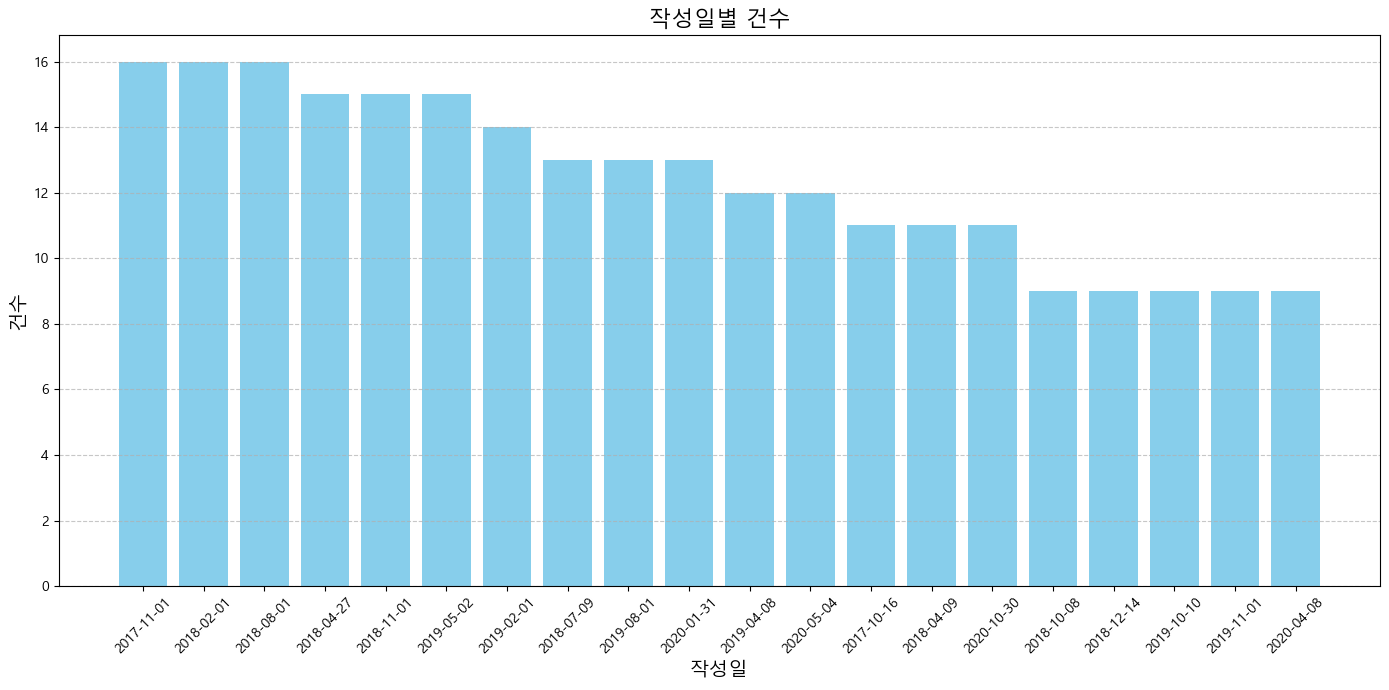

In [108]:
# 작성일별 건수 상위 20개 선택
df_count = df_count.nlargest(20, '건수')

# 그래프 그리기
plt.figure(figsize=(14, 7))
plt.bar(df_count['작성일'].dt.strftime('%Y-%m-%d'), df_count['건수'], color='skyblue')

plt.xlabel('작성일', fontsize=14)
plt.ylabel('건수', fontsize=14)
plt.title('작성일별 건수', fontsize=16)

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()